In [84]:
import struct
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
from captum.attr import LayerGradCam
import numpy as np
import matplotlib.pyplot as plt

# 1) LOADING THE MNIST DATASET

In [85]:
# Utility to load .idx files without torchvision.
def load_images_idx(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        data = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return data

def load_labels_idx(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Paths to data files
train_images = load_images_idx('data/train-images.idx3-ubyte')
train_labels = load_labels_idx('data/train-labels.idx1-ubyte')
test_images  = load_images_idx('data/t10k-images.idx3-ubyte')
test_labels  = load_labels_idx('data/t10k-labels.idx1-ubyte')

print("Train images shape:", train_images.shape)  # (60000, 28, 28)
print("Train labels shape:", train_labels.shape)  # (60000,)
print("Test images shape:",  test_images.shape)    # (10000, 28, 28)
print("Test labels shape:",  test_labels.shape)    # (10000,)


Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


# 2) DEFINING 3 PHASES OF TRAINING

In [86]:
# DEFINING 3 PHASES OF TRAINING
def filter_by_class(images, labels, keep_classes):
    # Return only images and labels belonging to keep_classes.
    mask = np.isin(labels, keep_classes)
    return images[mask], labels[mask]

def limit_samples_per_class(images, labels, max_per_class_map):

    new_imgs, new_lbls = [], []
    counts = {c:0 for c in max_per_class_map}
    for img, lbl in zip(images, labels):
        if lbl in max_per_class_map:
            if counts[lbl] < max_per_class_map[lbl]:
                new_imgs.append(img)
                new_lbls.append(lbl)
                counts[lbl] += 1
    return np.array(new_imgs), np.array(new_lbls)

# PHASE 1: classes [0..4], balanced (1000 each, and Balanced.

In [87]:
# PHASE 1: classes [0..4], balanced (1000 each, and Balanced.
p1_classes = [0,1,2,3,4]
p1_images, p1_labels = filter_by_class(train_images, train_labels, p1_classes)
maxmap_p1 = {0:1000, 1:1000, 2:1000, 3:1000, 4:1000}
p1_images, p1_labels = limit_samples_per_class(p1_images, p1_labels, maxmap_p1)

print("Phase 1:", p1_images.shape, p1_labels.shape, "Classes:", np.unique(p1_labels))

Phase 1: (5000, 28, 28) (5000,) Classes: [0 1 2 3 4]


# PHASE 2: classes [0..6], but classes 5,6 are heavily represented to create imbalance.

In [88]:
# PHASE 2: classes [0..6], but classes 5,6 are heavily represented to create imbalance.
p2_classes = [0,1,2,3,4,5,6]
p2_images, p2_labels = filter_by_class(train_images, train_labels, p2_classes)
# Random number of each class to match real word imbalanced data
maxmap_p2 = {0:1000, 1:800, 2:750, 3:900, 4:250, 5:2000, 6:2000}
p2_images, p2_labels = limit_samples_per_class(p2_images, p2_labels, maxmap_p2)

print("Phase 2:", p2_images.shape, p2_labels.shape, "Classes:", np.unique(p2_labels))

Phase 2: (7700, 28, 28) (7700,) Classes: [0 1 2 3 4 5 6]


# PHASE 3: Reintroduce classes [7..9], plus keeping [0..6] but re-balanced

In [89]:
# PHASE 3: Reintroduce classes [7..9], plus keep [0..6] but re-balanced
p3_classes = [0,1,2,3,4,5,6,7,8,9]
p3_images, p3_labels = filter_by_class(train_images, train_labels, p3_classes)
maxmap_p3 = {0:920, 1:920, 2:920, 3:920, 4:920, 5:920, 6:920, 7:920, 8:920, 9:920}
p3_images, p3_labels = limit_samples_per_class(p3_images, p3_labels, maxmap_p3)

print("Phase 3:", p3_images.shape, p3_labels.shape, "Classes:", np.unique(p3_labels))

Phase 3: (9200, 28, 28) (9200,) Classes: [0 1 2 3 4 5 6 7 8 9]


# 3) CREATE TORCH DATASETS & DATALOADERS

In [90]:
# CREATE TORCH DATASETS & DATALOADERS
def create_dataloader(images, labels, batch_size=64):
    # images: shape (N, 28, 28)
    # Convert to float tensor [N,1,28,28]
    images_t = torch.from_numpy(images).float().unsqueeze(1) / 255.0
    labels_t = torch.from_numpy(labels).long()
    dataset = TensorDataset(images_t, labels_t)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

phase1_loader = create_dataloader(p1_images, p1_labels, batch_size=64)
phase2_loader = create_dataloader(p2_images, p2_labels, batch_size=64)
phase3_loader = create_dataloader(p3_images, p3_labels, batch_size=64)

# For final evaluation, keep the official test set (with all 10 classes).
test_images_t = torch.from_numpy(test_images).float().unsqueeze(1)/255.0
test_labels_t = torch.from_numpy(test_labels).long()
test_dataset = TensorDataset(test_images_t, test_labels_t)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("DataLoader Phase1 length:", len(phase1_loader))
print("DataLoader Phase2 length:", len(phase2_loader))
print("DataLoader Phase3 length:", len(phase3_loader))


DataLoader Phase1 length: 79
DataLoader Phase2 length: 121
DataLoader Phase3 length: 144


# 4) DEFINE A CNN MODEL

In [91]:
# DEFINE A CNN MODEL
class SimpleCNN(nn.Module):
    # Convolution operation formula:
    # (I * K)(i, j) = sum_m sum_n I(i - m, j - n) * K(m, n)
    # where I is the input image, K is the kernel, and (i, j) is the pixel coordinates of the output feature map.
    # The indices m and n iterate over the spatial dimensions of the kernel.
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Three convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    return correct / total


# 5) TRAINING IN PHASES

In [92]:
# TRAINING IN PHASES
def train_model(model, train_loader, epochs=10, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, lbls in train_loader:
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f}")

# 5.1) PHASE 1: Train from scratch

In [93]:
# PHASE 1: Train from scratch
model_phase1 = SimpleCNN(num_classes=10)
print("Training on Phase 1 (classes 0..4) balanced:")
train_model(model_phase1, phase1_loader, epochs=15, lr=0.001)
acc_test = evaluate(model_phase1, test_loader)
print(f"Test Accuracy after Phase 1: {acc_test*100:.2f}%\n")

# Save the Phase 1 model to disk
torch.save(model_phase1.state_dict(), "model_phase1.pth")

Training on Phase 1 (classes 0..4) balanced:
Epoch [1/15] | Loss: 0.6264
Epoch [2/15] | Loss: 0.1309
Epoch [3/15] | Loss: 0.0925
Epoch [4/15] | Loss: 0.0699
Epoch [5/15] | Loss: 0.0493
Epoch [6/15] | Loss: 0.0368
Epoch [7/15] | Loss: 0.0327
Epoch [8/15] | Loss: 0.0290
Epoch [9/15] | Loss: 0.0200
Epoch [10/15] | Loss: 0.0147
Epoch [11/15] | Loss: 0.0133
Epoch [12/15] | Loss: 0.0089
Epoch [13/15] | Loss: 0.0080
Epoch [14/15] | Loss: 0.0068
Epoch [15/15] | Loss: 0.0050
Test Accuracy after Phase 1: 51.02%


# 5.2) PHASE 2: Start from Phase 1's weights

In [94]:
# PHASE 2: Start from Phase 1's weights
model_phase2 = SimpleCNN(num_classes=10)
model_phase2.load_state_dict(torch.load("model_phase1.pth"))

print("Fine-tuning on Phase 2 (classes 0..6, imbalanced):")
train_model(model_phase2, phase2_loader, epochs=15, lr=0.0005)
acc_test = evaluate(model_phase2, test_loader)
print(f"Test Accuracy after Phase 2: {acc_test*100:.2f}%\n")

torch.save(model_phase2.state_dict(), "model_phase2.pth")

Fine-tuning on Phase 2 (classes 0..6, imbalanced):
Epoch [1/15] | Loss: 1.3892
Epoch [2/15] | Loss: 0.0917
Epoch [3/15] | Loss: 0.0564
Epoch [4/15] | Loss: 0.0399
Epoch [5/15] | Loss: 0.0309
Epoch [6/15] | Loss: 0.0259
Epoch [7/15] | Loss: 0.0210
Epoch [8/15] | Loss: 0.0175
Epoch [9/15] | Loss: 0.0156
Epoch [10/15] | Loss: 0.0128
Epoch [11/15] | Loss: 0.0105
Epoch [12/15] | Loss: 0.0109
Epoch [13/15] | Loss: 0.0083
Epoch [14/15] | Loss: 0.0067
Epoch [15/15] | Loss: 0.0084
Test Accuracy after Phase 2: 69.09%


# 5.3) PHASE 3: Start from Phase 2's weights

In [95]:
# PHASE 3: Start from Phase 2's weights
model_phase3 = SimpleCNN(num_classes=10)
model_phase3.load_state_dict(torch.load("model_phase2.pth"))

print("Fine-tuning on Phase 3 (all classes 0..9, rebalanced):")
train_model(model_phase3, phase3_loader, epochs=15, lr=0.0005)
acc_test = evaluate(model_phase3, test_loader)
print(f"Test Accuracy after Phase 3: {acc_test*100:.2f}%\n")

torch.save(model_phase3.state_dict(), "model_phase3.pth")

Fine-tuning on Phase 3 (all classes 0..9, rebalanced):
Epoch [1/15] | Loss: 1.0579
Epoch [2/15] | Loss: 0.1207
Epoch [3/15] | Loss: 0.0820
Epoch [4/15] | Loss: 0.0635
Epoch [5/15] | Loss: 0.0507
Epoch [6/15] | Loss: 0.0445
Epoch [7/15] | Loss: 0.0365
Epoch [8/15] | Loss: 0.0295
Epoch [9/15] | Loss: 0.0267
Epoch [10/15] | Loss: 0.0220
Epoch [11/15] | Loss: 0.0187
Epoch [12/15] | Loss: 0.0163
Epoch [13/15] | Loss: 0.0132
Epoch [14/15] | Loss: 0.0121
Epoch [15/15] | Loss: 0.0098
Test Accuracy after Phase 3: 97.72%


# 6) Compute Intersection-over-Union (IoU) between two heatmaps.

In [96]:
def compute_iou(heatmapA, heatmapB, threshold=0.5):
    # Normalize heatmaps to range [0,1]
    heatmapA = (heatmapA - heatmapA.min()) / (heatmapA.max() - heatmapA.min() + 1e-8)
    heatmapB = (heatmapB - heatmapB.min()) / (heatmapB.max() - heatmapB.min() + 1e-8)

    # Convert heatmaps to binary masks
    maskA = heatmapA > threshold
    maskB = heatmapB > threshold

    # Compute intersection and union
    intersection = np.logical_and(maskA, maskB).sum()
    union = np.logical_or(maskA, maskB).sum()

    # Avoid division by zero
    return intersection / union if union > 0 else 0

# 7) Generating Grad-CAM Explanations Across Phases

In [97]:
# GENERATE GRAD-CAM & COMPARE
def generate_gradcam(model, input_tensor, class_label):
    """
    input_tensor: shape [1,1,28,28]
    returns a 2D heatmap (numpy array)
    """
    model.eval()
    target_layer = model.conv2  
    gradcam = LayerGradCam(model, target_layer)

    class_label = int(class_label)

    attributions = gradcam.attribute(input_tensor, target=class_label)
    heatmap = attributions.squeeze().detach().numpy()
    return heatmap


def heatmap_corr(hmA, hmB):
    # Flatten & normalize two heatmaps, then compute correlation in [-1,1].
    A = hmA.flatten()
    B = hmB.flatten()
    A_norm = A / (A.max() + 1e-8)
    B_norm = B / (B.max() + 1e-8)
    corr = np.corrcoef(A_norm, B_norm)[0,1]
    return corr


# 7.1) Generating Grad-CAM Explanations For Stability Across Phases

In [98]:
# Pick number of images
N = 5000
sample_imgs = p1_images[:N]   
sample_lbls = p1_labels[:N] 

import torch

sample_imgs_t = torch.from_numpy(sample_imgs).float().unsqueeze(1)/255.0  

corr_12_list = []
corr_23_list = []
corr_13_list = []

for i in range(N):
    # single image, shape [1,1,28,28]
    img_t = sample_imgs_t[i].unsqueeze(0)
    lbl   = sample_lbls[i]

    hm_p1 = generate_gradcam(model_phase1, img_t, lbl)
    hm_p2 = generate_gradcam(model_phase2, img_t, lbl)
    hm_p3 = generate_gradcam(model_phase3, img_t, lbl)

    c12 = heatmap_corr(hm_p1, hm_p2)
    c23 = heatmap_corr(hm_p2, hm_p3)
    c13 = heatmap_corr(hm_p1, hm_p3)

    corr_12_list.append(c12)
    corr_23_list.append(c23)
    corr_13_list.append(c13)

    print(f"Image {i}, label={lbl}, Corr(1->2)={c12:.3f}, Corr(2->3)={c23:.3f}, Corr(1->3)={c13:.3f}")

print("\n=== AVERAGE CORRELATIONS FOR THESE 5 IMAGES ===")
print(f"Phase1->Phase2: {np.mean(corr_12_list):.3f}")
print(f"Phase2->Phase3: {np.mean(corr_23_list):.3f}")
print(f"Phase1->Phase3: {np.mean(corr_13_list):.3f}")

Image 0, label=0, Corr(1->2)=0.100, Corr(2->3)=0.905, Corr(1->3)=-0.204
Image 1, label=4, Corr(1->2)=0.880, Corr(2->3)=0.669, Corr(1->3)=0.376
Image 2, label=1, Corr(1->2)=0.943, Corr(2->3)=0.789, Corr(1->3)=0.583
Image 3, label=2, Corr(1->2)=0.834, Corr(2->3)=0.640, Corr(1->3)=0.167
Image 4, label=1, Corr(1->2)=0.920, Corr(2->3)=0.094, Corr(1->3)=-0.094
Image 5, label=3, Corr(1->2)=0.622, Corr(2->3)=0.639, Corr(1->3)=-0.141
Image 6, label=1, Corr(1->2)=0.921, Corr(2->3)=-0.105, Corr(1->3)=-0.133
Image 7, label=4, Corr(1->2)=0.830, Corr(2->3)=0.399, Corr(1->3)=-0.118
Image 8, label=3, Corr(1->2)=0.553, Corr(2->3)=0.705, Corr(1->3)=-0.147
Image 9, label=3, Corr(1->2)=0.758, Corr(2->3)=0.281, Corr(1->3)=-0.336
Image 10, label=1, Corr(1->2)=0.946, Corr(2->3)=0.591, Corr(1->3)=0.394
Image 11, label=2, Corr(1->2)=0.884, Corr(2->3)=0.145, Corr(1->3)=0.072
Image 12, label=4, Corr(1->2)=0.909, Corr(2->3)=0.184, Corr(1->3)=-0.139
Image 13, label=0, Corr(1->2)=0.303, Corr(2->3)=0.812, Corr(1->3)

# 7.2) Generating Grad-CAM Explanations For Consistency Across Phases

In [99]:
iou_12_list = []
iou_23_list = []
iou_13_list = []

N = 5000  # Number of test images
sample_imgs_t = torch.from_numpy(p1_images[:N]).float().unsqueeze(1) / 255.0  
sample_lbls = p1_labels[:N]  

for i in range(N):
    img_t = sample_imgs_t[i].unsqueeze(0)  # [1,1,28,28]
    lbl   = sample_lbls[i]

    # Generate Grad-CAM heatmaps for each phase
    hm_p1 = generate_gradcam(model_phase1, img_t, lbl)
    hm_p2 = generate_gradcam(model_phase2, img_t, lbl)
    hm_p3 = generate_gradcam(model_phase3, img_t, lbl)

    # Compute IoU scores
    iou12 = compute_iou(hm_p1, hm_p2)
    iou23 = compute_iou(hm_p2, hm_p3)
    iou13 = compute_iou(hm_p1, hm_p3)

    iou_12_list.append(iou12)
    iou_23_list.append(iou23)
    iou_13_list.append(iou13)

    print(f"Image {i}, Label={lbl}, IoU(1->2)={iou12:.3f}, IoU(2->3)={iou23:.3f}, IoU(1->3)={iou13:.3f}")

# Compute Average IoU Across All Images
avg_iou_12 = np.mean(iou_12_list)
avg_iou_23 = np.mean(iou_23_list)
avg_iou_13 = np.mean(iou_13_list)

print(f"\n=== AVERAGE IoU FOR {N} IMAGES ===")
print(f"IoU(Phase 1 -> 2): {avg_iou_12:.3f}")
print(f"IoU(Phase 2 -> 3): {avg_iou_23:.3f}")
print(f"IoU(Phase 1 -> 3): {avg_iou_13:.3f}")


Image 0, Label=0, IoU(1->2)=0.170, IoU(2->3)=0.902, IoU(1->3)=0.146
Image 1, Label=4, IoU(1->2)=0.690, IoU(2->3)=0.184, IoU(1->3)=0.149
Image 2, Label=1, IoU(1->2)=0.875, IoU(2->3)=0.600, IoU(1->3)=0.516
Image 3, Label=2, IoU(1->2)=0.661, IoU(2->3)=0.238, IoU(1->3)=0.209
Image 4, Label=1, IoU(1->2)=0.656, IoU(2->3)=0.117, IoU(1->3)=0.104
Image 5, Label=3, IoU(1->2)=0.519, IoU(2->3)=0.372, IoU(1->3)=0.190
Image 6, Label=1, IoU(1->2)=0.774, IoU(2->3)=0.120, IoU(1->3)=0.111
Image 7, Label=4, IoU(1->2)=0.718, IoU(2->3)=0.131, IoU(1->3)=0.100
Image 8, Label=3, IoU(1->2)=0.382, IoU(2->3)=0.222, IoU(1->3)=0.093
Image 9, Label=3, IoU(1->2)=0.594, IoU(2->3)=0.188, IoU(1->3)=0.116
Image 10, Label=1, IoU(1->2)=0.958, IoU(2->3)=0.109, IoU(1->3)=0.115
Image 11, Label=2, IoU(1->2)=0.737, IoU(2->3)=0.167, IoU(1->3)=0.139
Image 12, Label=4, IoU(1->2)=0.791, IoU(2->3)=0.162, IoU(1->3)=0.136
Image 13, Label=0, IoU(1->2)=0.196, IoU(2->3)=0.863, IoU(1->3)=0.135
Image 14, Label=1, IoU(1->2)=0.810, IoU(2->3

# 7.3) Heatmaps Explanations For Consistency Across Phases

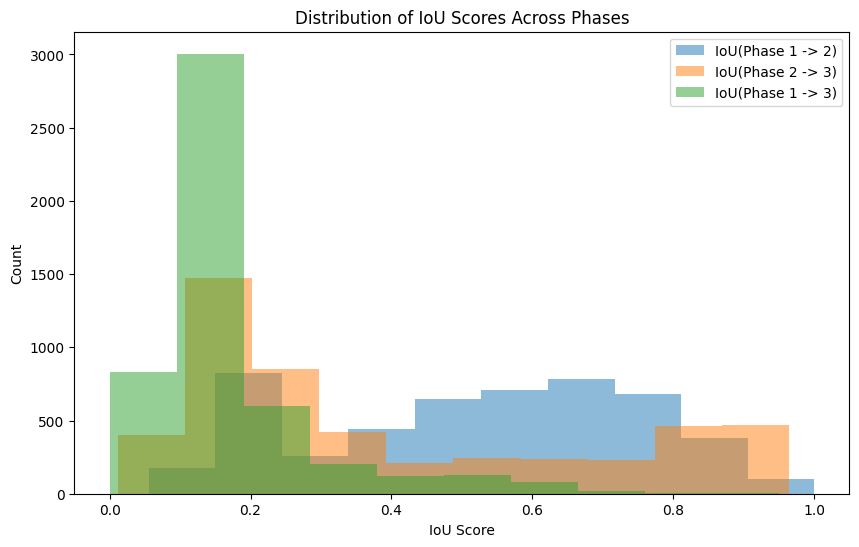

In [100]:
plt.figure(figsize=(10,6))
plt.hist(iou_12_list, bins=10, alpha=0.5, label='IoU(Phase 1 -> 2)')
plt.hist(iou_23_list, bins=10, alpha=0.5, label='IoU(Phase 2 -> 3)')
plt.hist(iou_13_list, bins=10, alpha=0.5, label='IoU(Phase 1 -> 3)')
plt.xlabel('IoU Score')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of IoU Scores Across Phases')
plt.show()


# 7.4) Heatmaps Explanations For Stability Across Phases

Avg Corr(Phase1->2) over 5000 images: 0.653
Avg Corr(Phase2->3) over 5000 images: 0.589
Avg Corr(Phase1->3) over 5000 images: 0.030


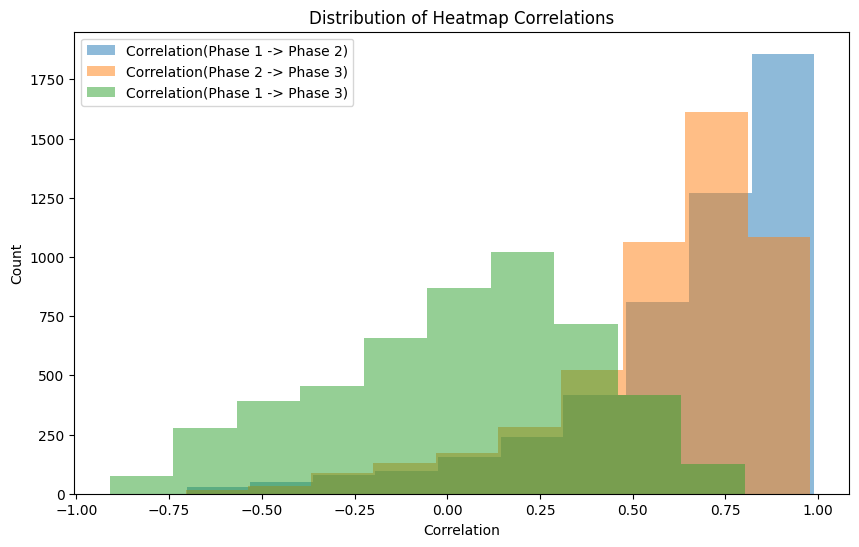

In [101]:
N = 5000  
sample_imgs = p1_images[:N]  
sample_lbls = p1_labels[:N] 

sample_imgs_t = torch.from_numpy(sample_imgs).float().unsqueeze(1)/255.0

corr_12_list = []
corr_23_list = []
corr_13_list = []

for i in range(N):
    img_t = sample_imgs_t[i].unsqueeze(0)
    lbl = sample_lbls[i]

    hm_p1 = generate_gradcam(model_phase1, img_t, lbl)
    hm_p2 = generate_gradcam(model_phase2, img_t, lbl)
    hm_p3 = generate_gradcam(model_phase3, img_t, lbl)

    c12 = heatmap_corr(hm_p1, hm_p2)
    c23 = heatmap_corr(hm_p2, hm_p3)
    c13 = heatmap_corr(hm_p1, hm_p3)

    corr_12_list.append(c12)
    corr_23_list.append(c23)
    corr_13_list.append(c13)

# Summaries
avg12 = np.mean(corr_12_list)
avg23 = np.mean(corr_23_list)
avg13 = np.mean(corr_13_list)

print(f"Avg Corr(Phase1->2) over {N} images: {avg12:.3f}")
print(f"Avg Corr(Phase2->3) over {N} images: {avg23:.3f}")
print(f"Avg Corr(Phase1->3) over {N} images: {avg13:.3f}")

# Plot histograms for distribution
plt.figure(figsize=(10,6))
plt.hist(corr_12_list, bins=10, alpha=0.5, label='Correlation(Phase 1 -> Phase 2)')
plt.hist(corr_23_list, bins=10, alpha=0.5, label='Correlation(Phase 2 -> Phase 3)')
plt.hist(corr_13_list, bins=10, alpha=0.5, label='Correlation(Phase 1 -> Phase 3)')
plt.title('Distribution of Heatmap Correlations')
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.legend()
plt.show()


# 7.5) Compare Heatmaps Explanations For Both Stability and Consistency Across Phases

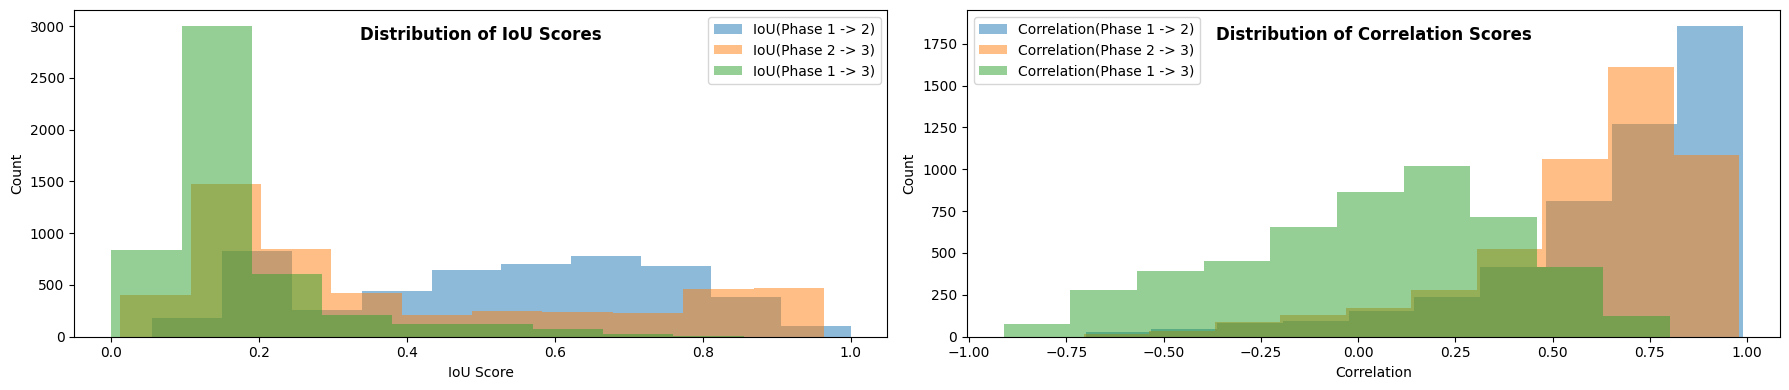

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))

# Left plot: IoU histograms
axs[0].hist(iou_12_list, bins=10, alpha=0.5, label='IoU(Phase 1 -> 2)')
axs[0].hist(iou_23_list, bins=10, alpha=0.5, label='IoU(Phase 2 -> 3)')
axs[0].hist(iou_13_list, bins=10, alpha=0.5, label='IoU(Phase 1 -> 3)')
axs[0].set_xlabel('IoU Score')
axs[0].set_ylabel('Count')
axs[0].legend()
# Add a title inside the left plot (coordinates in axes fraction)
axs[0].text(0.5, 0.95, 'Distribution of IoU Scores', 
            horizontalalignment='center', verticalalignment='top', 
            transform=axs[0].transAxes, fontsize=12, fontweight='bold')

# Right plot: Correlation histograms
axs[1].hist(corr_12_list, bins=10, alpha=0.5, label='Correlation(Phase 1 -> 2)')
axs[1].hist(corr_23_list, bins=10, alpha=0.5, label='Correlation(Phase 2 -> 3)')
axs[1].hist(corr_13_list, bins=10, alpha=0.5, label='Correlation(Phase 1 -> 3)')
axs[1].set_xlabel('Correlation')
axs[1].set_ylabel('Count')
axs[1].legend()
# Add a title inside the right plot
axs[1].text(0.5, 0.95, 'Distribution of Correlation Scores', 
            horizontalalignment='center', verticalalignment='top', 
            transform=axs[1].transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


# 8) Grad-CAM heatmaps showcasing intensity variations Across Phases

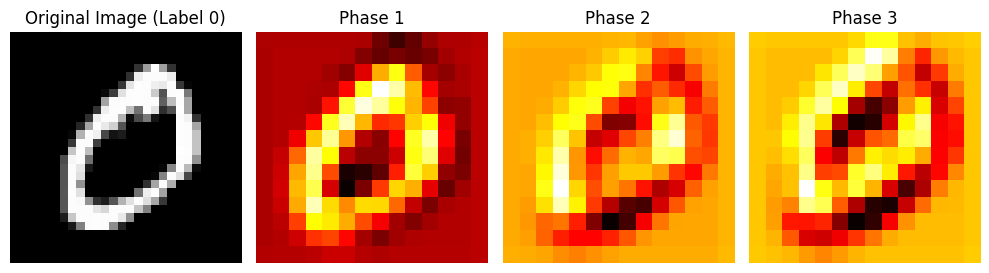

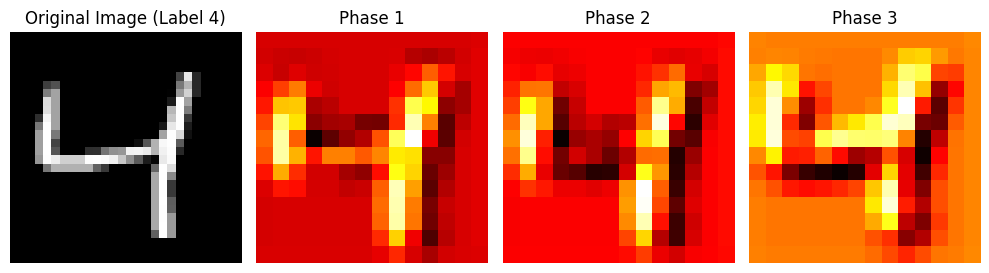

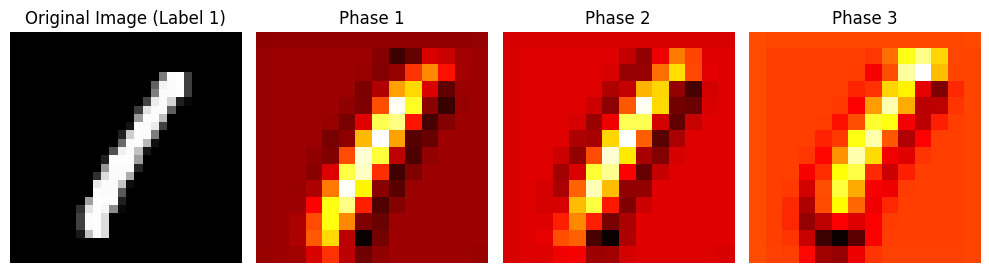

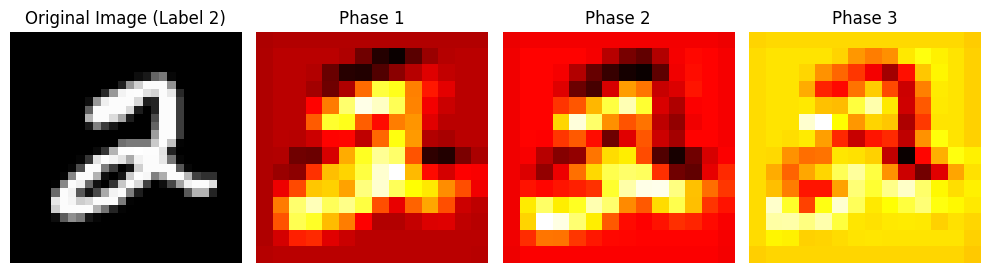

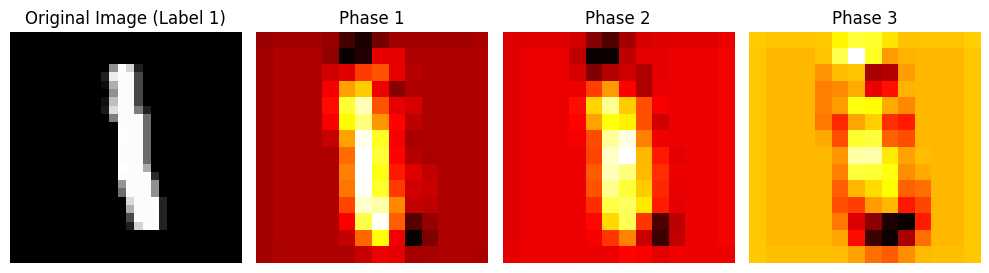

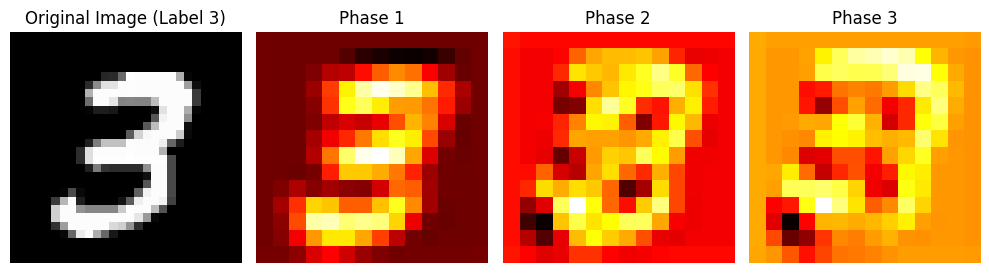

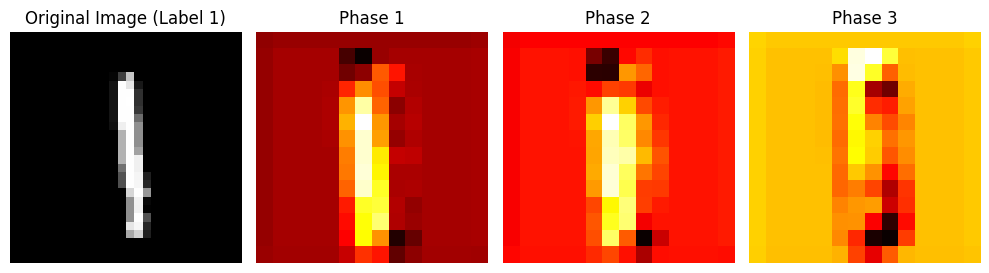

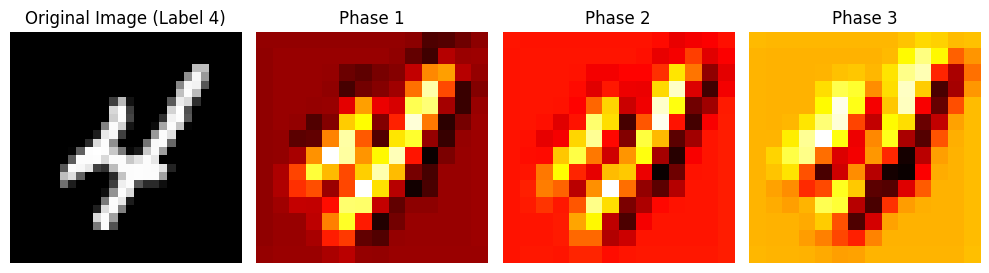

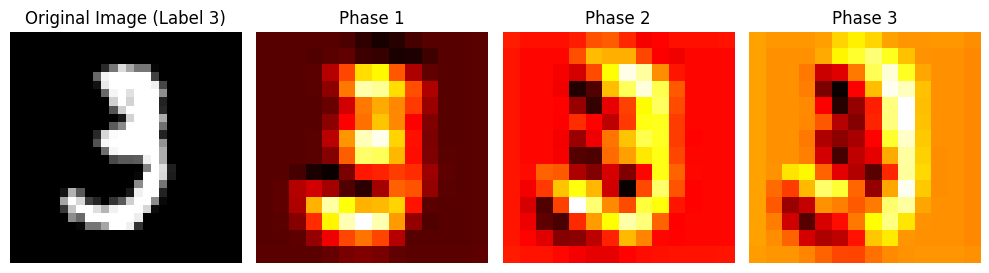

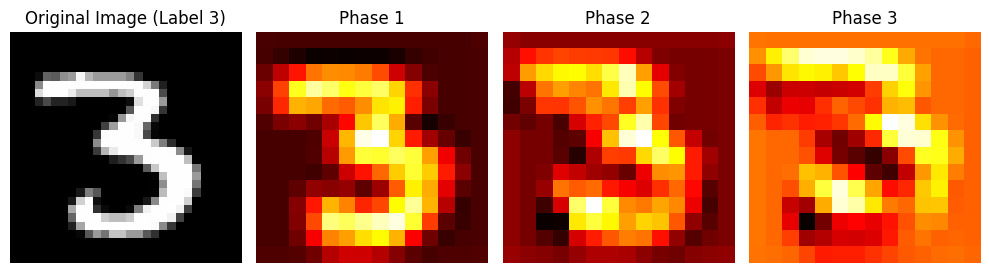

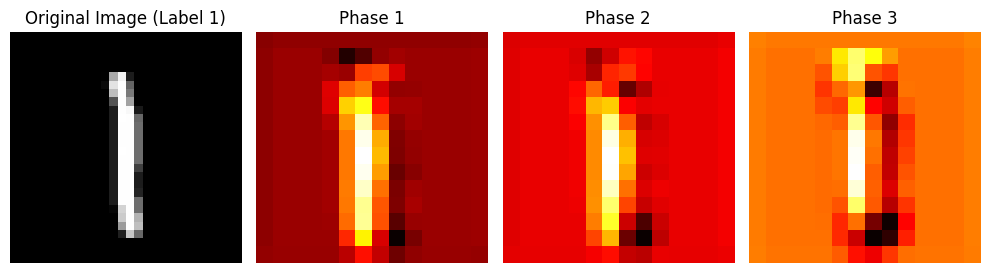

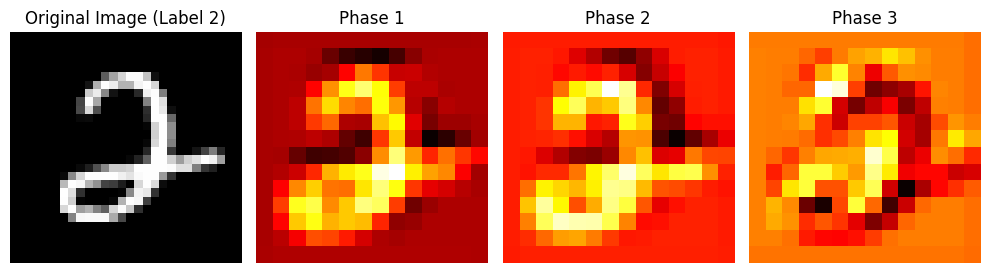

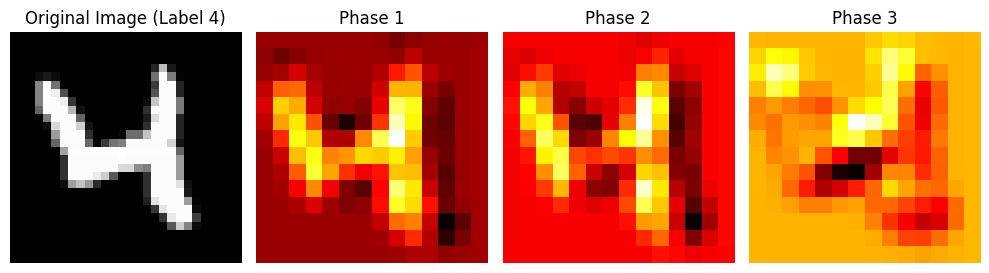

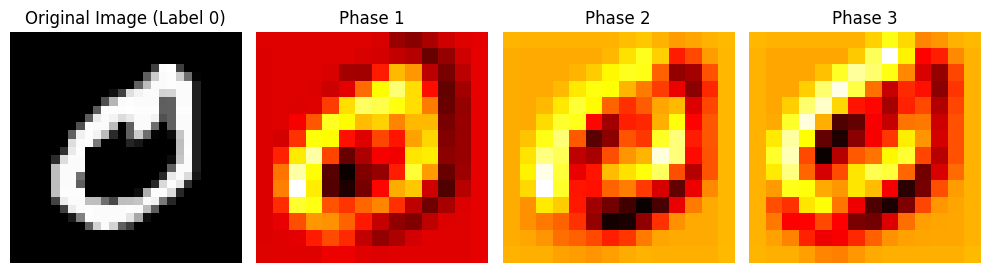

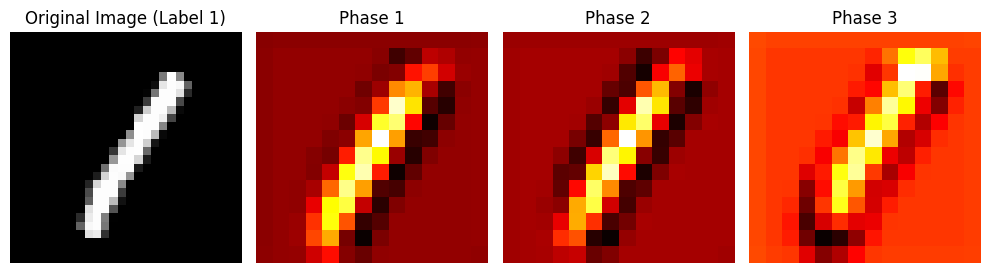

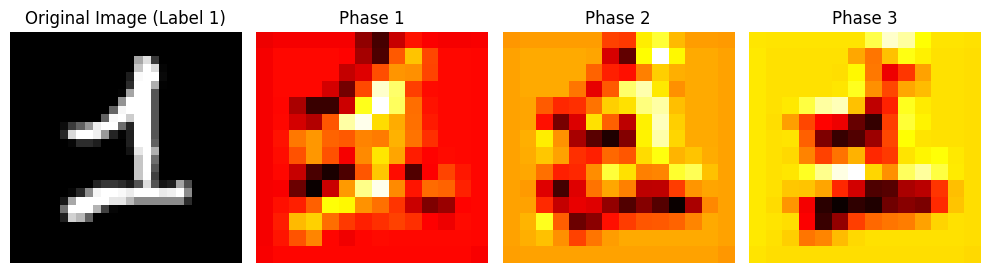

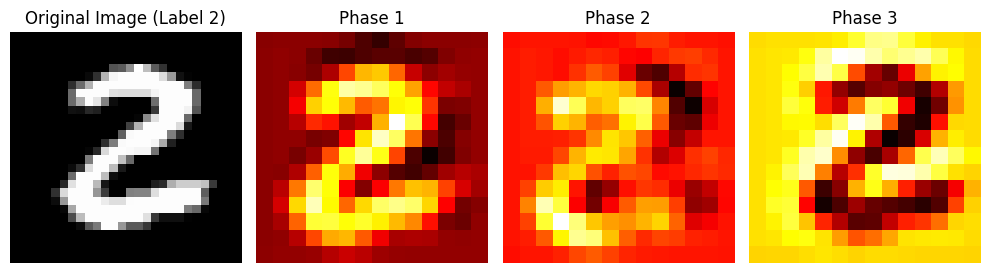

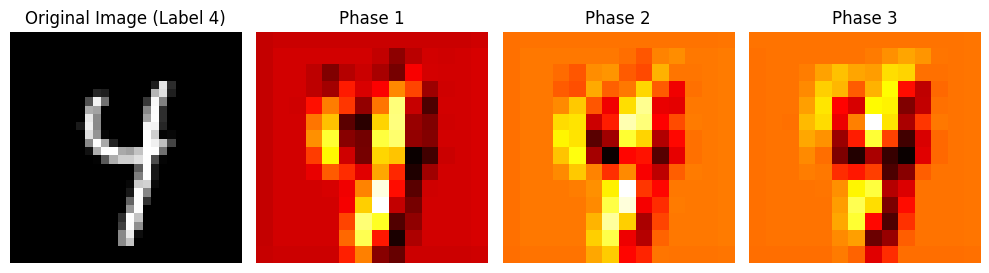

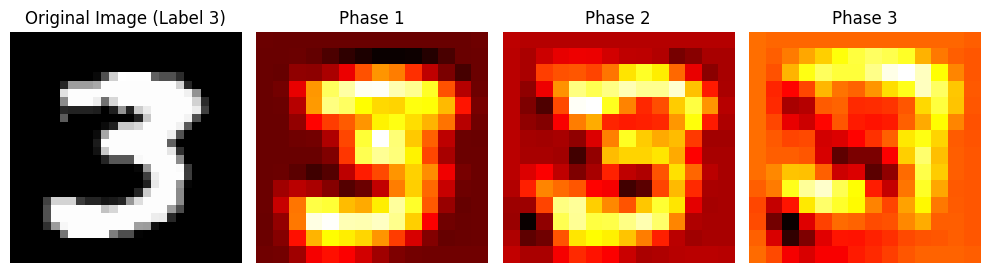

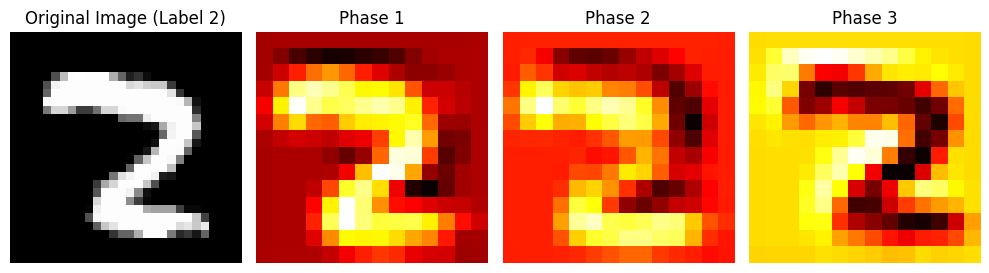

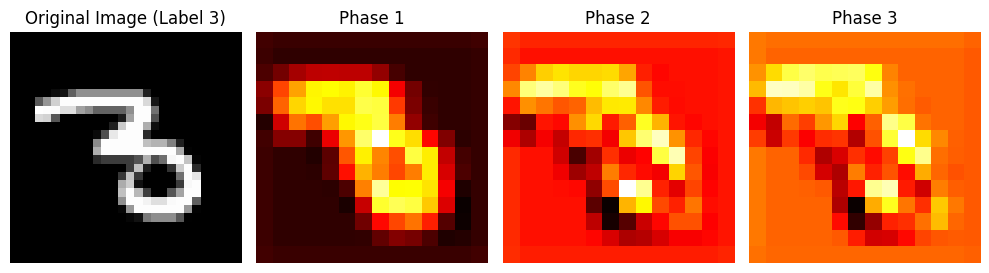

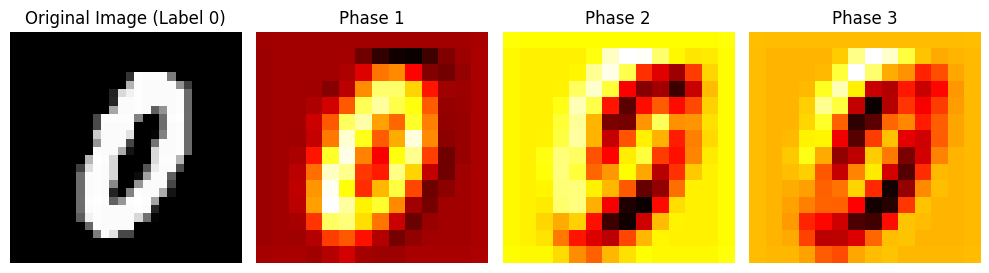

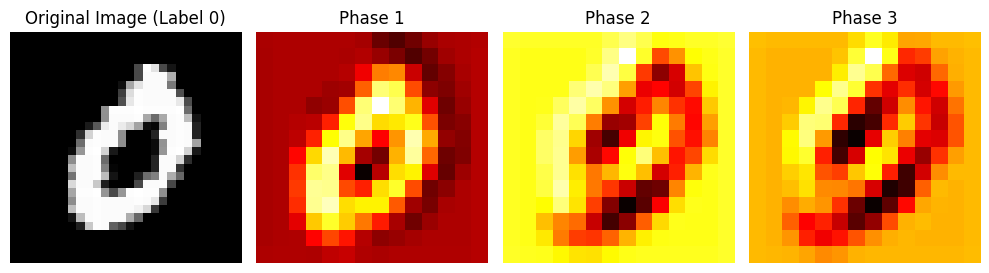

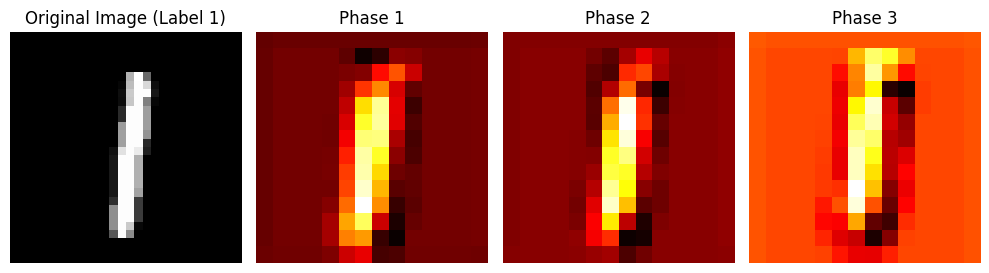

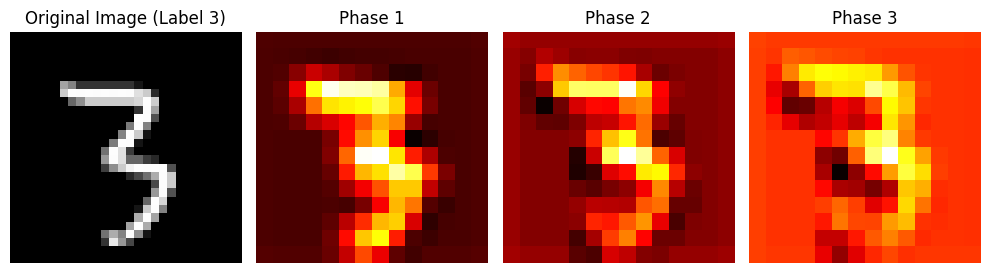

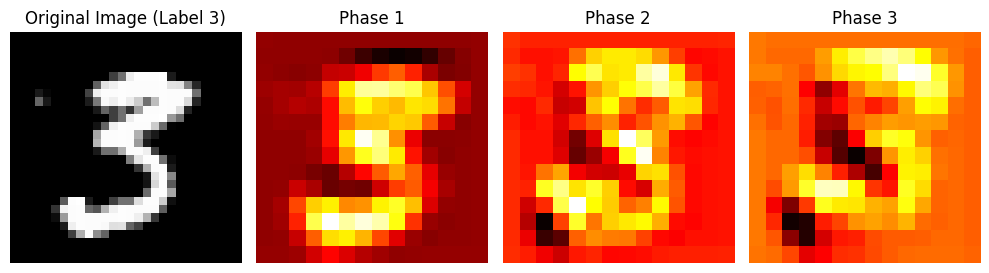

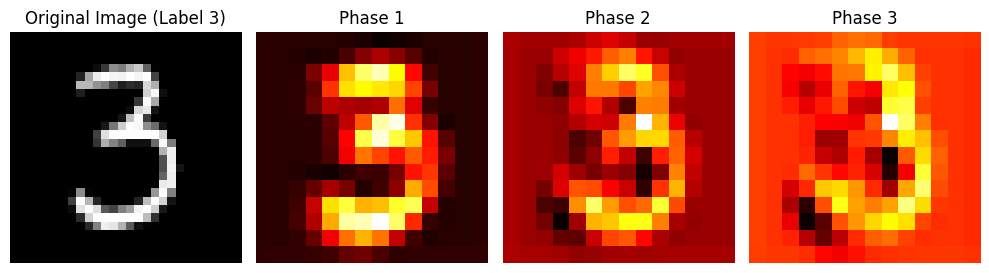

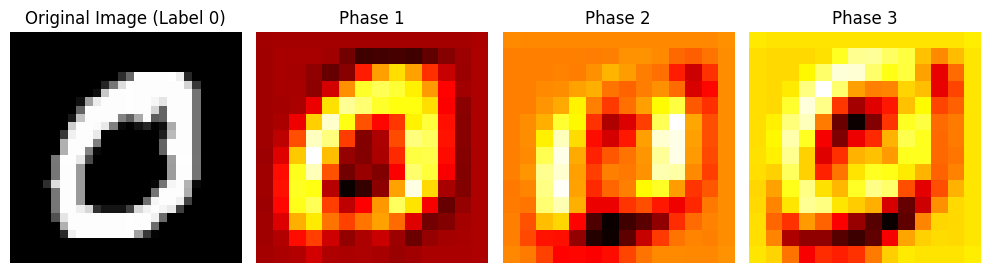

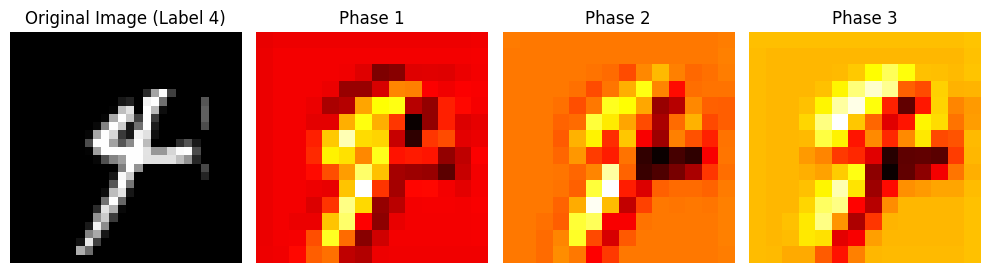

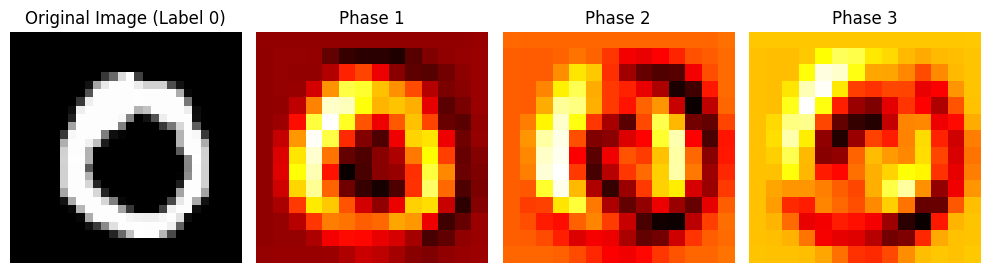

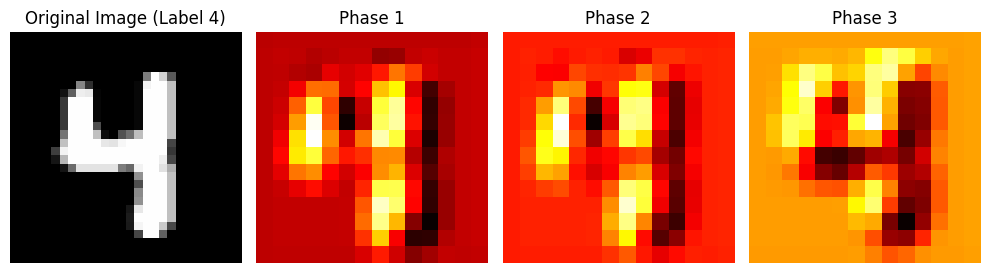

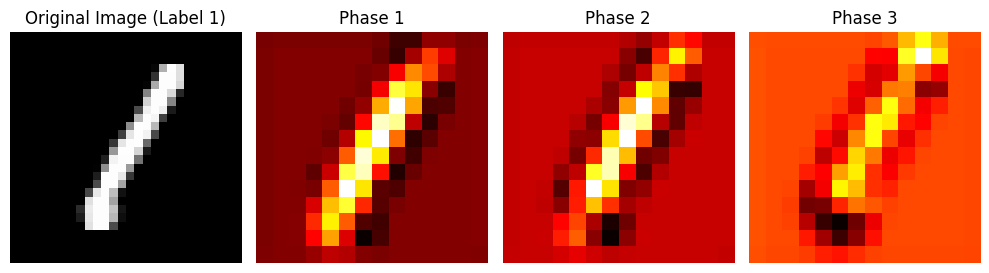

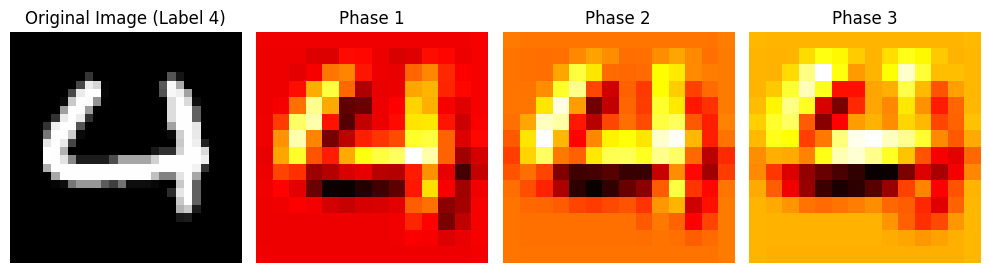

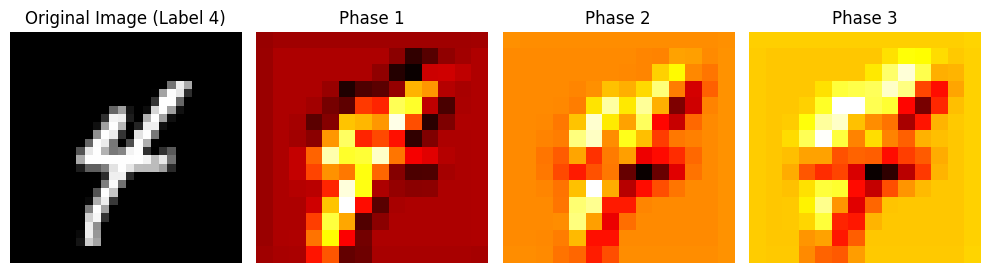

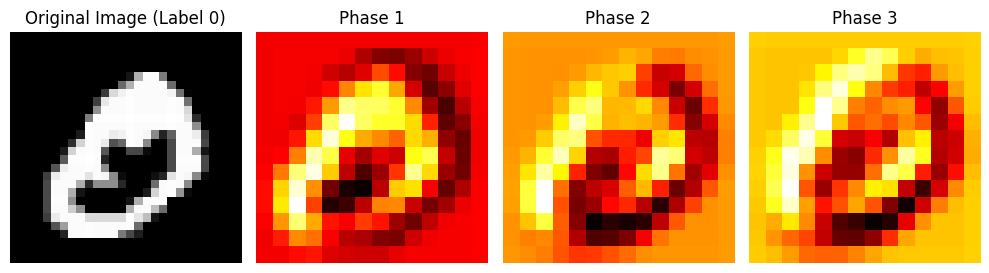

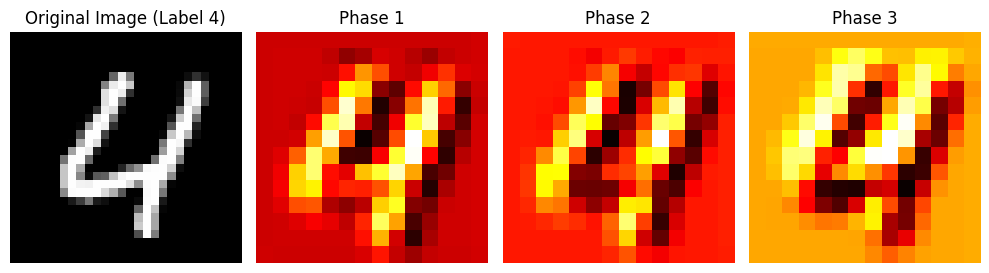

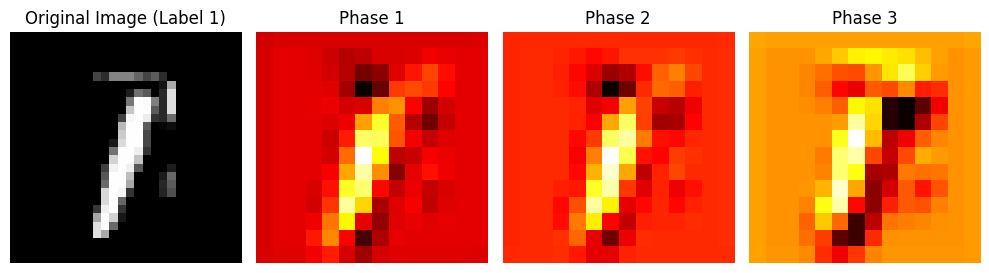

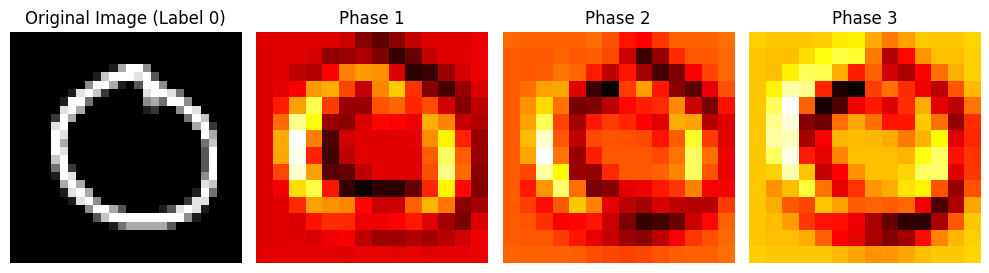

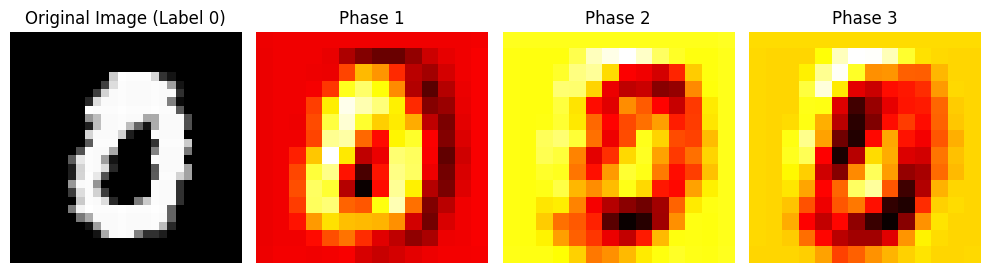

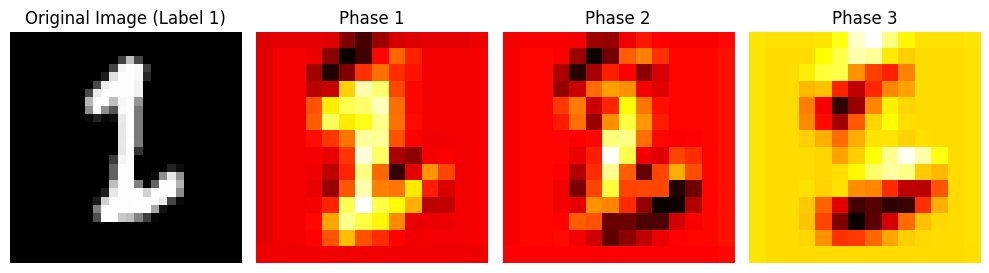

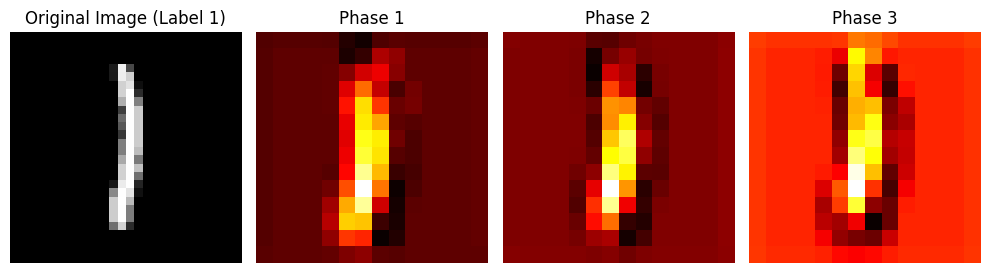

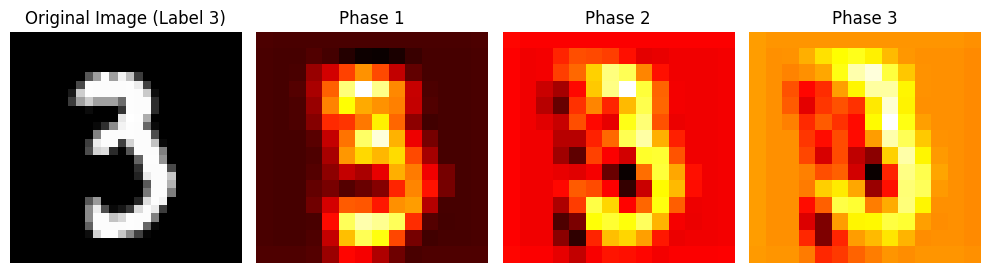

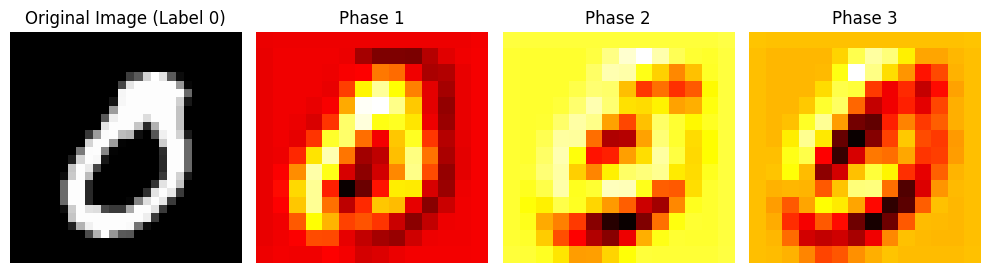

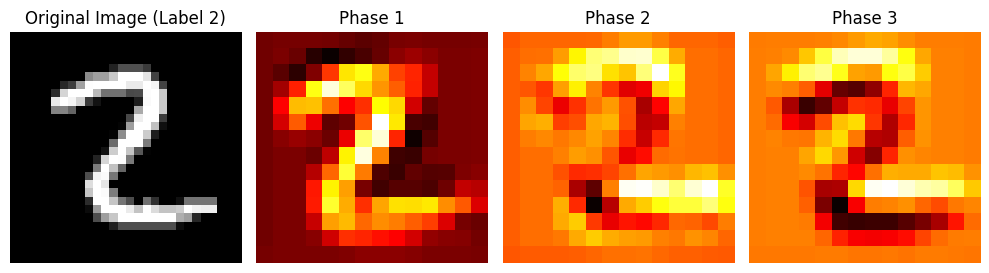

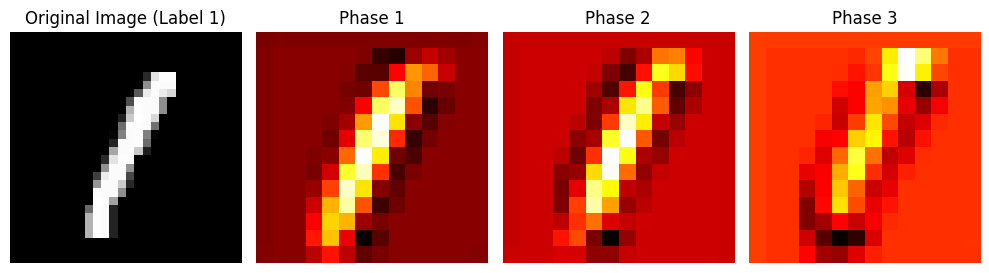

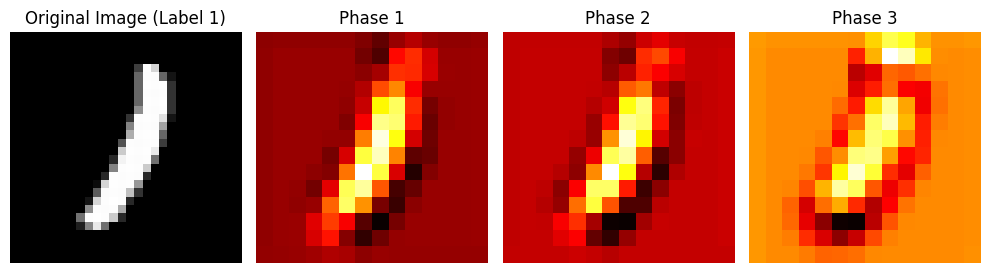

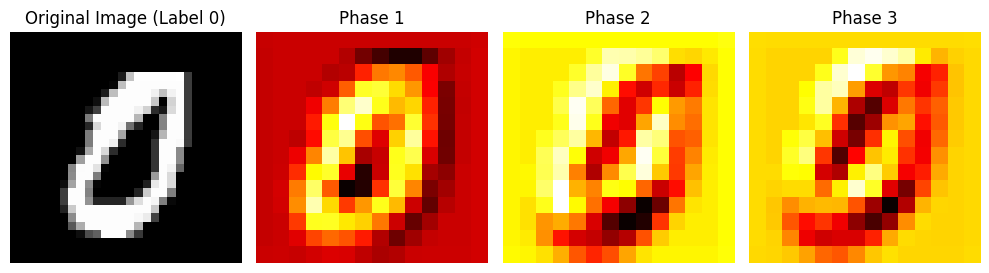

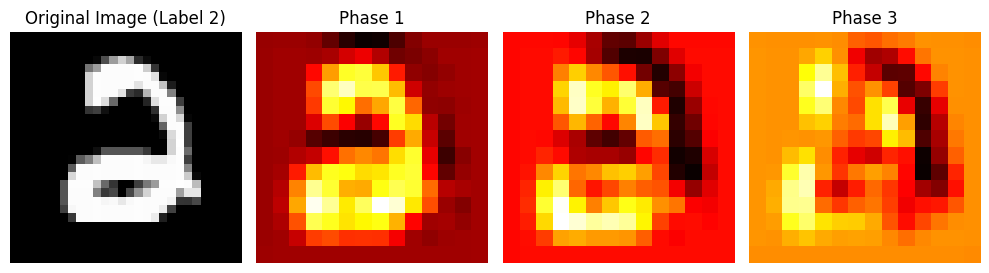

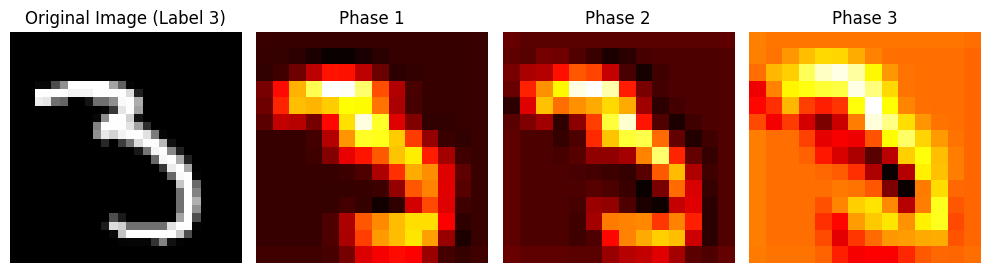

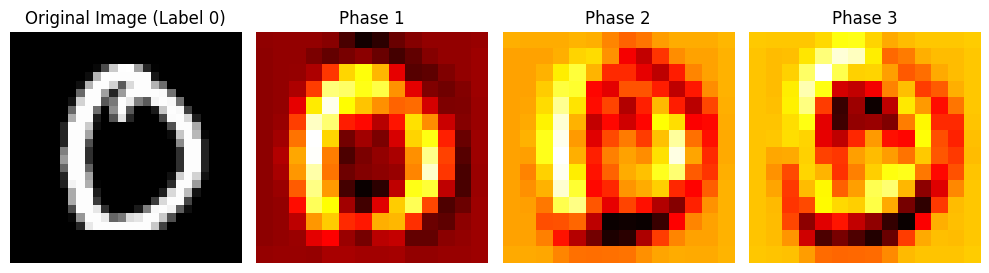

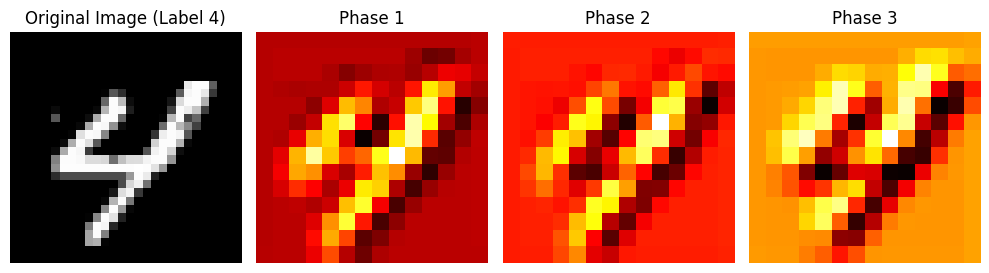

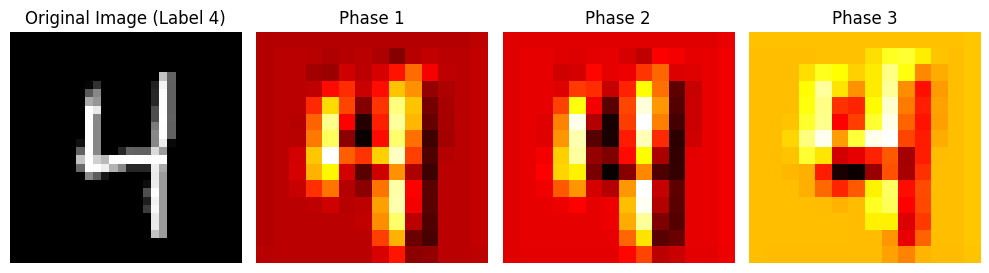

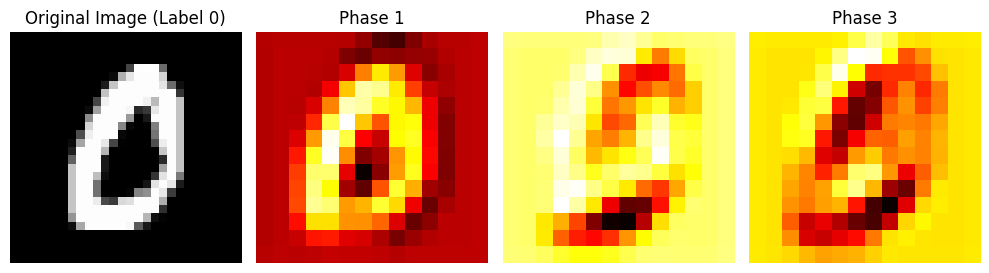

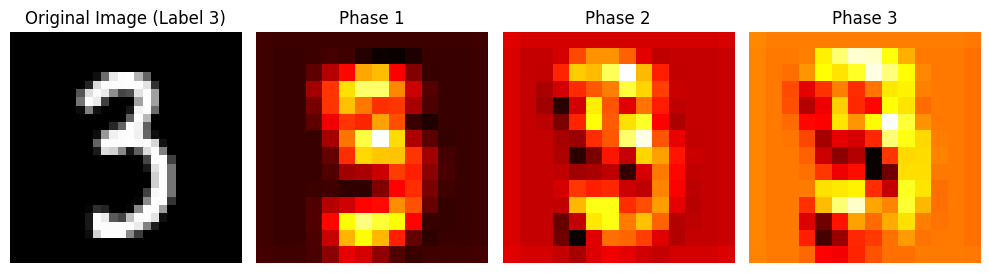

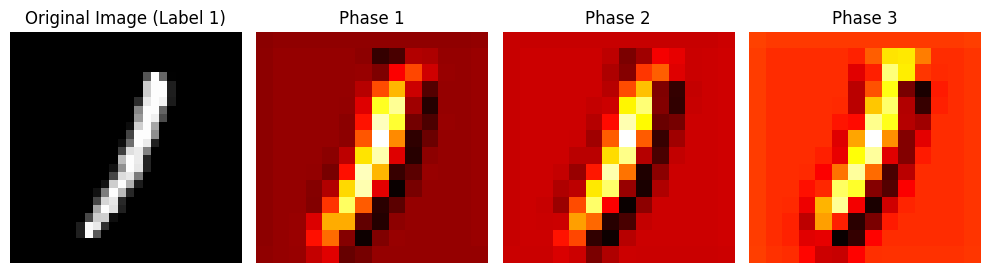

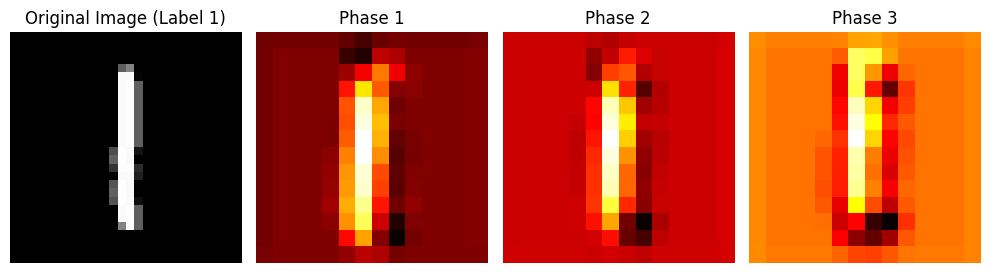

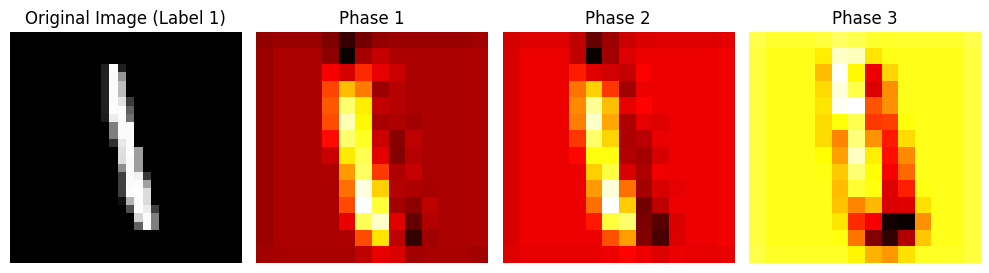

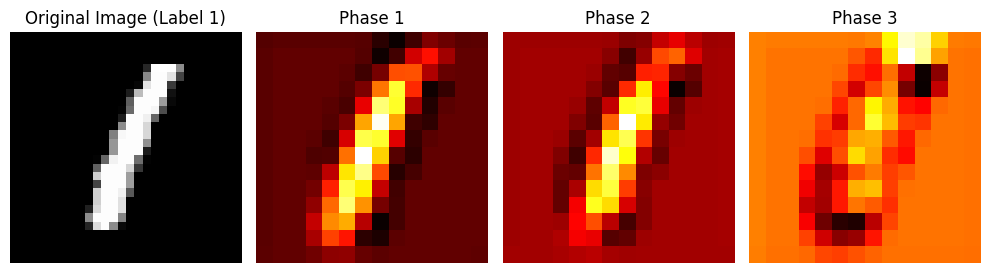

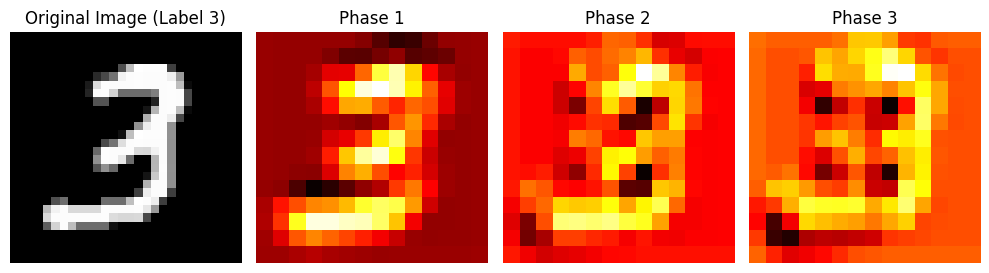

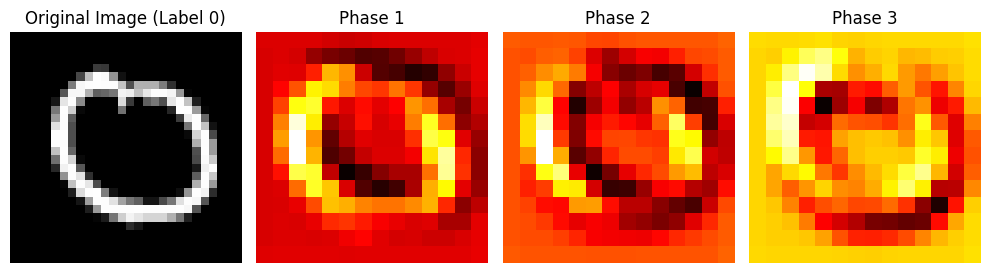

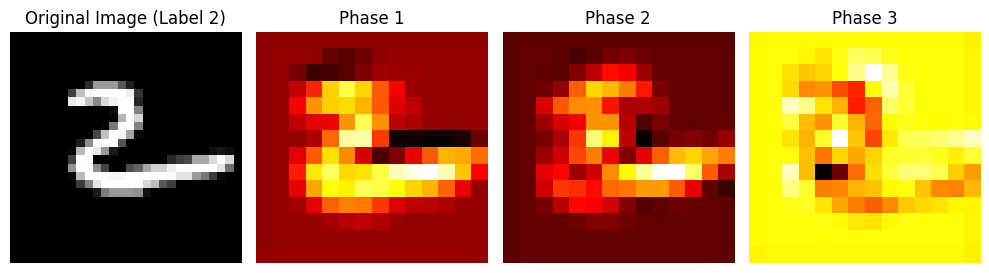

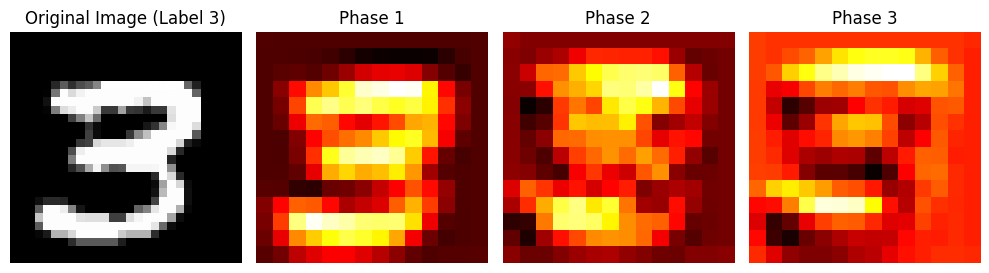

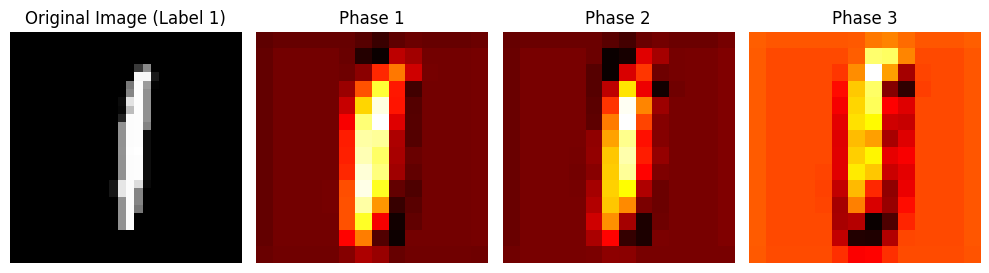

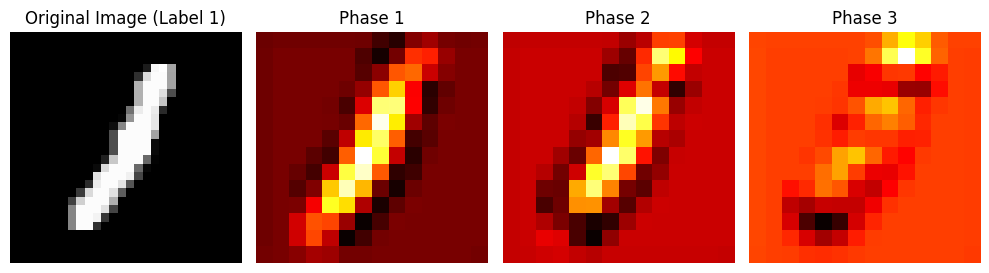

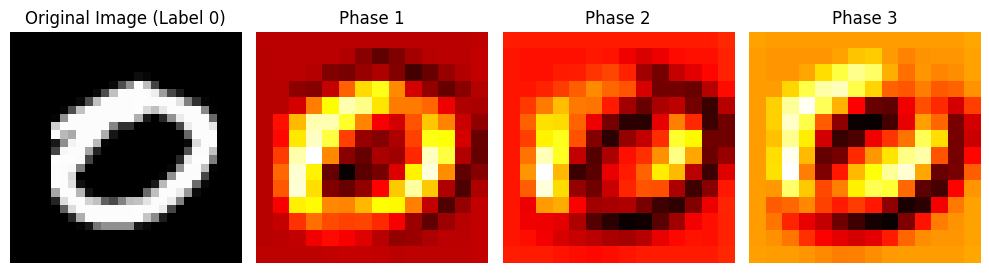

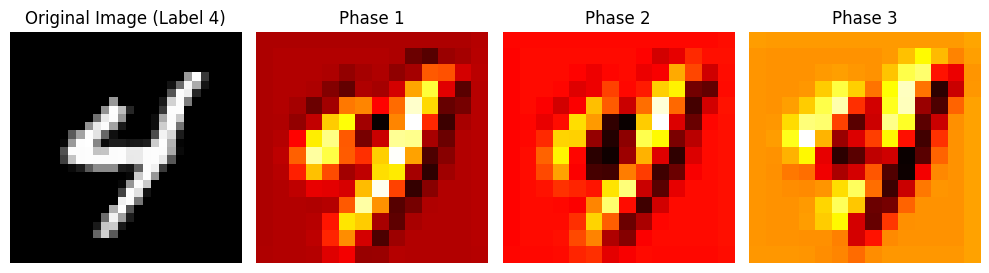

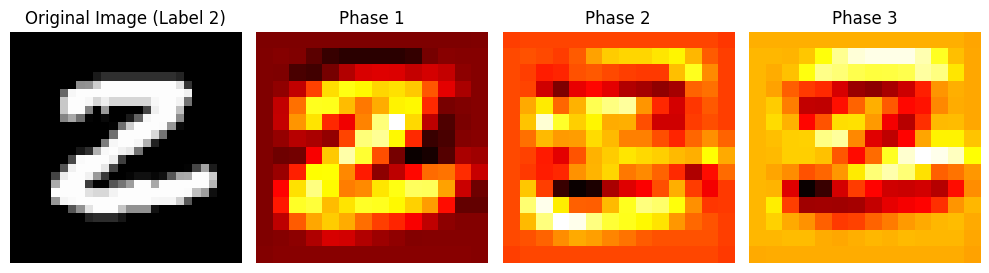

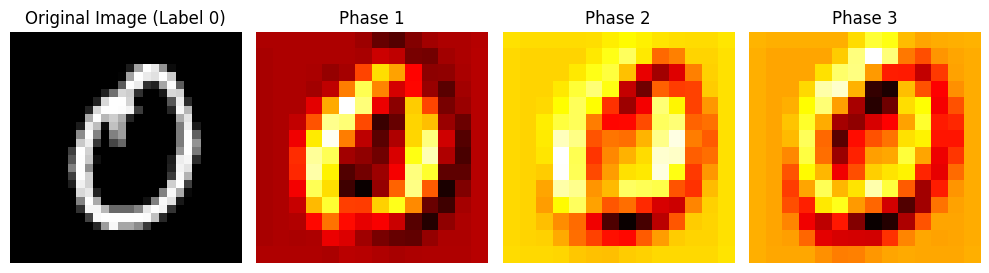

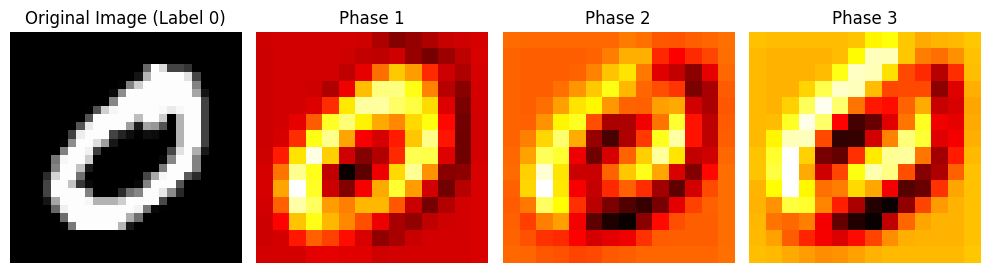

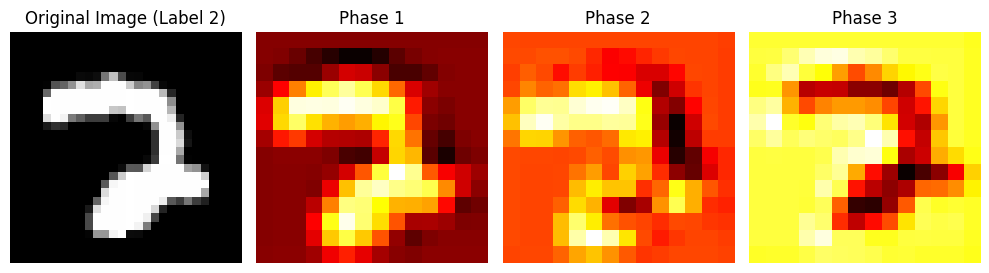

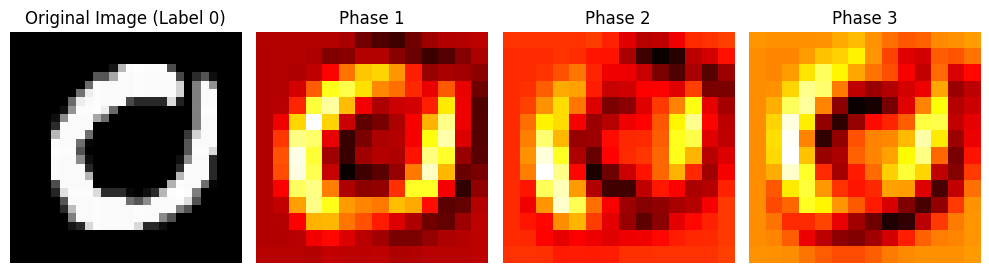

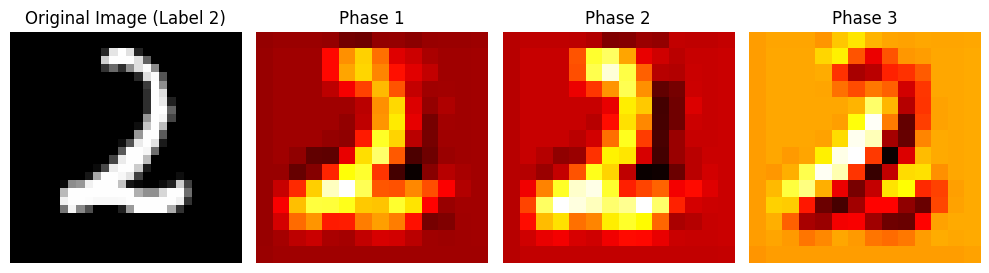

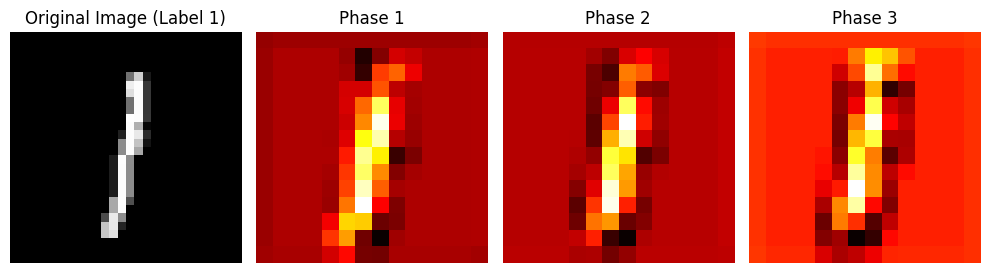

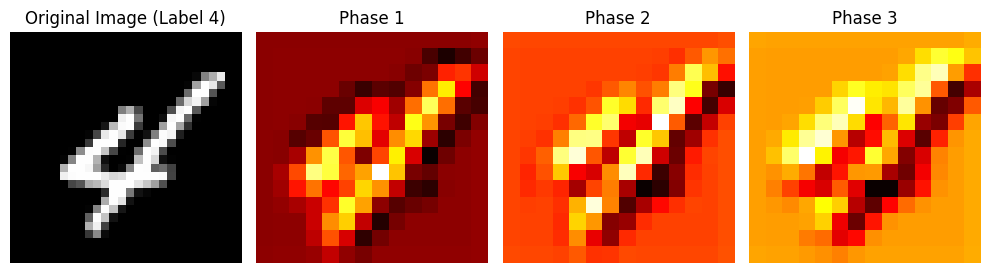

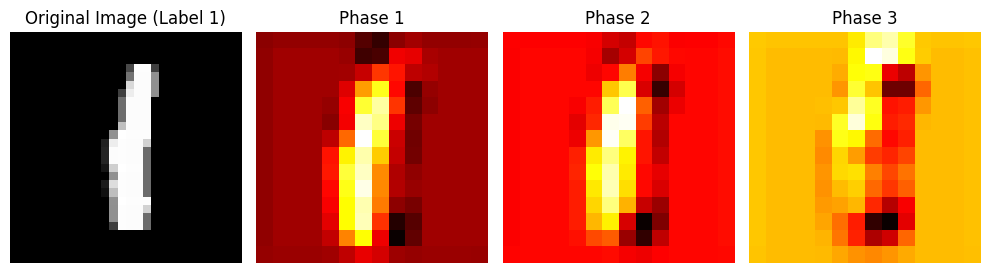

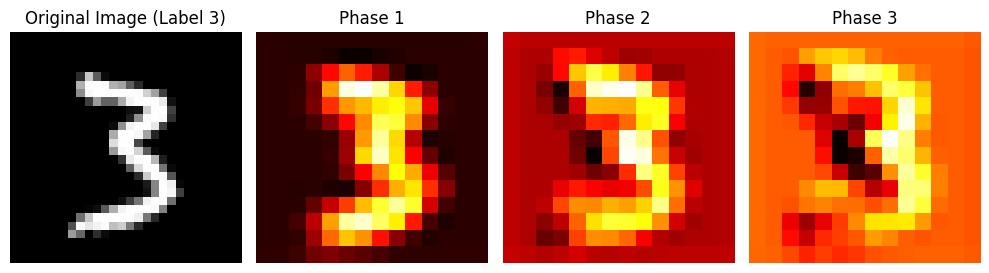

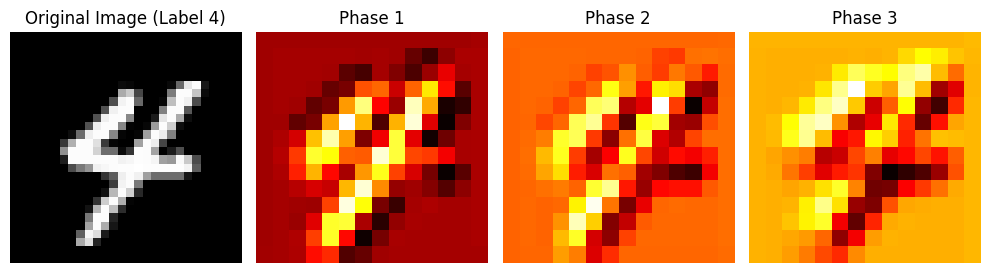

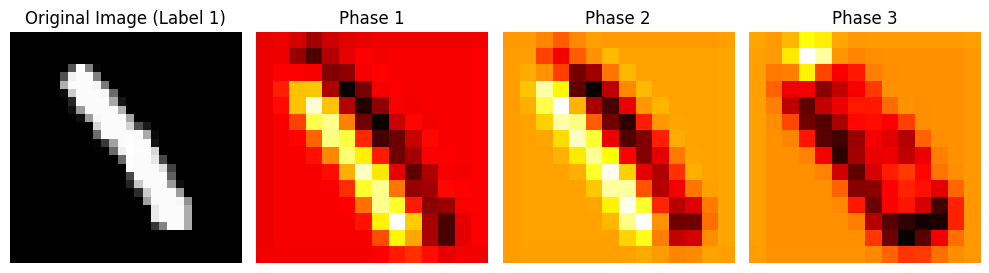

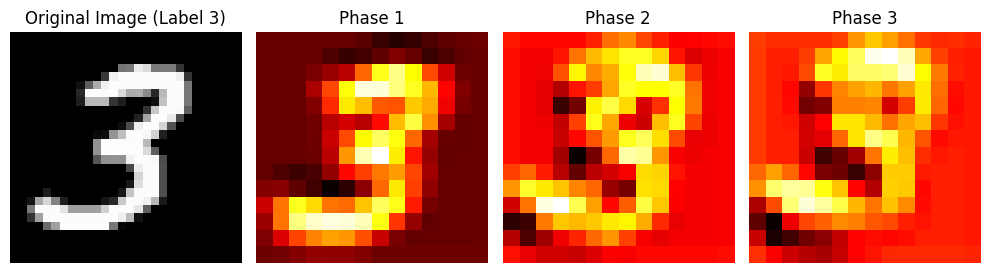

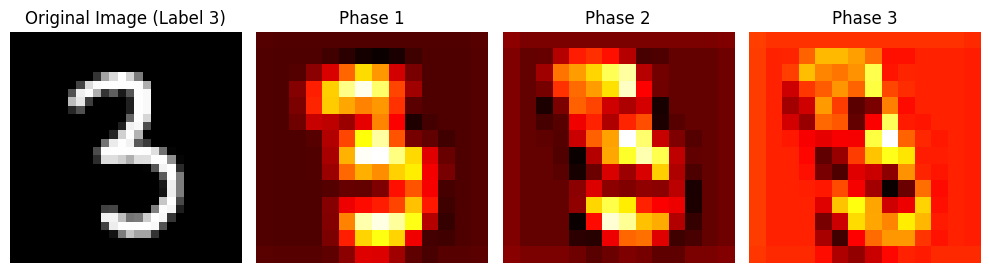

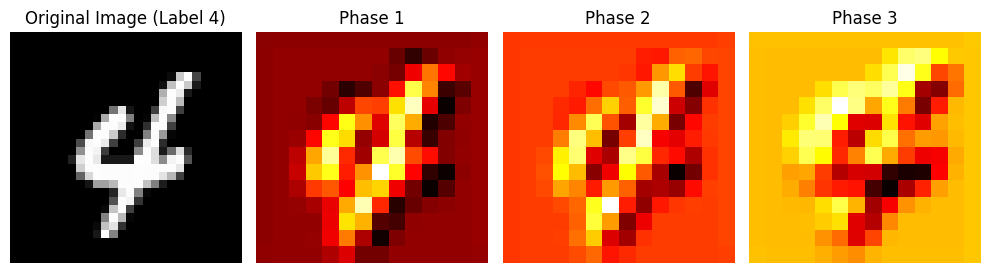

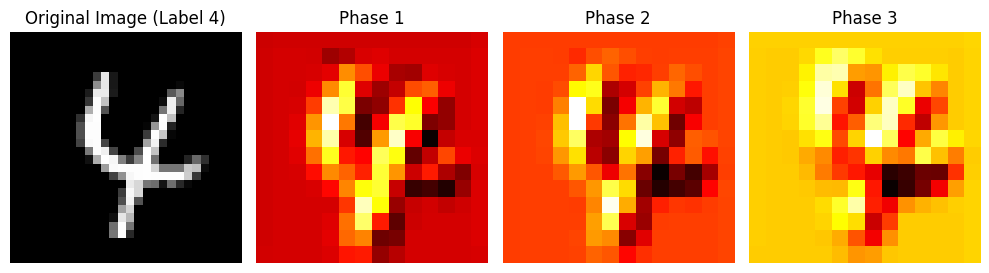

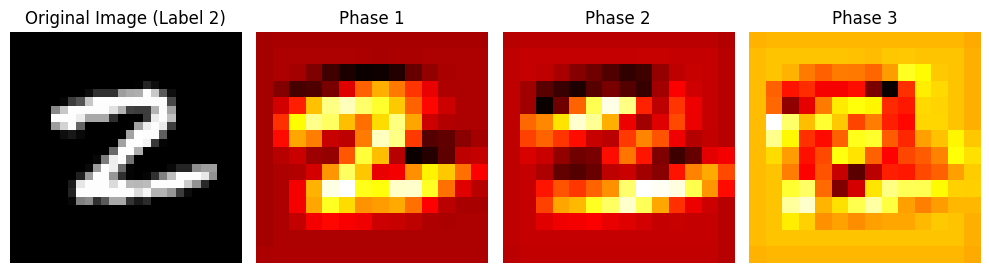

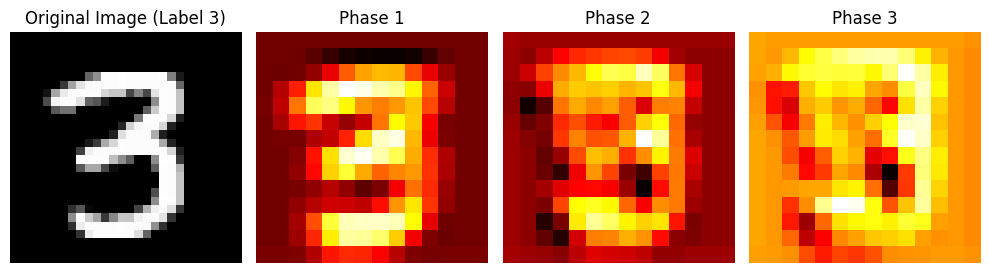

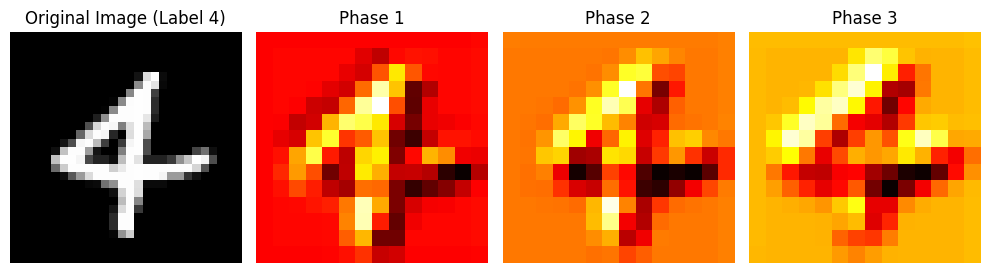

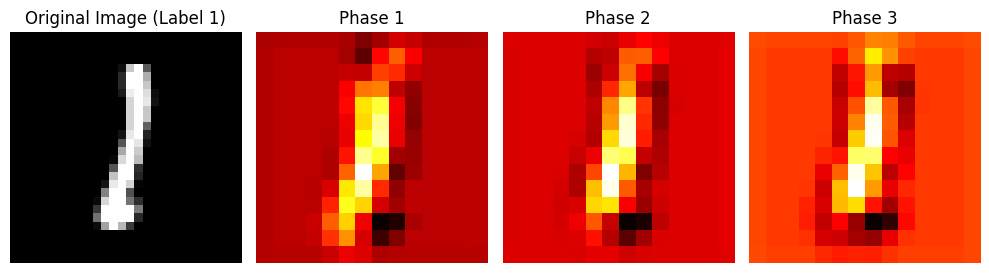

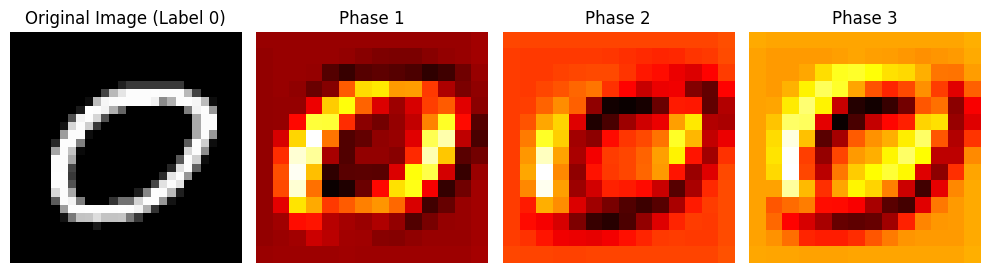

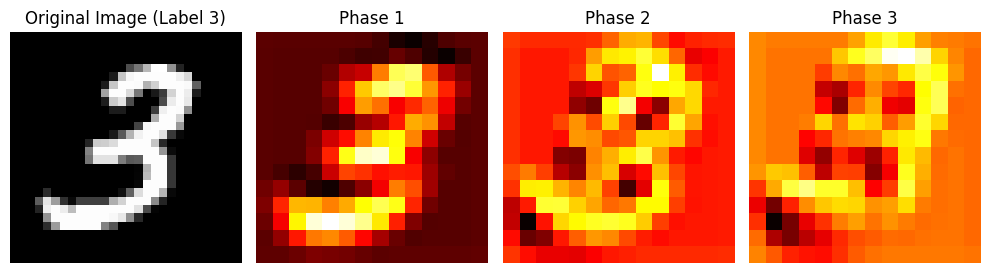

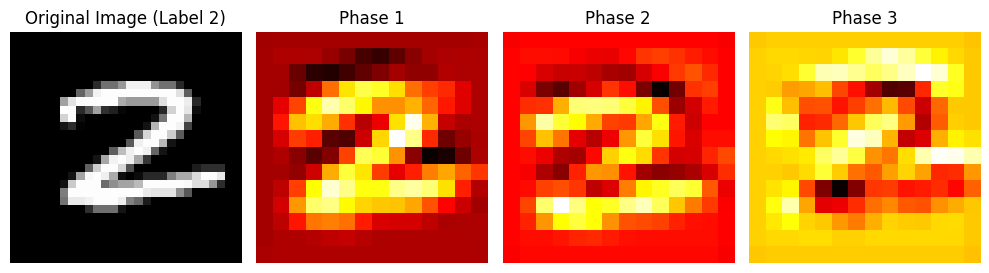

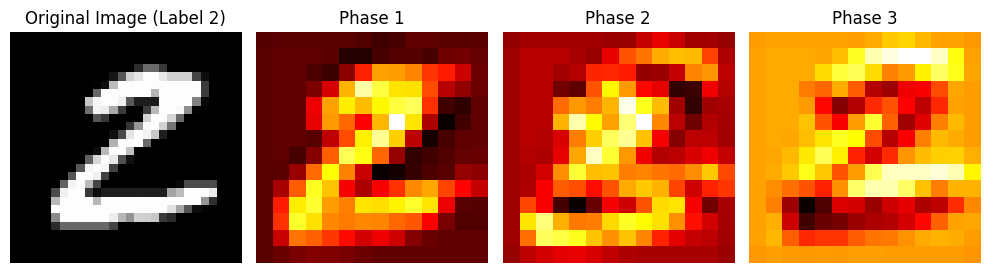

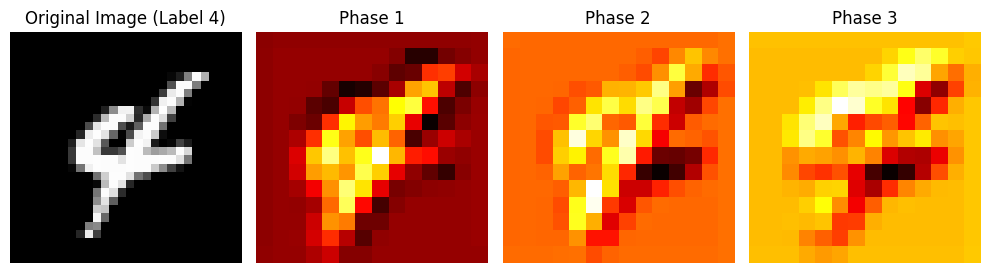

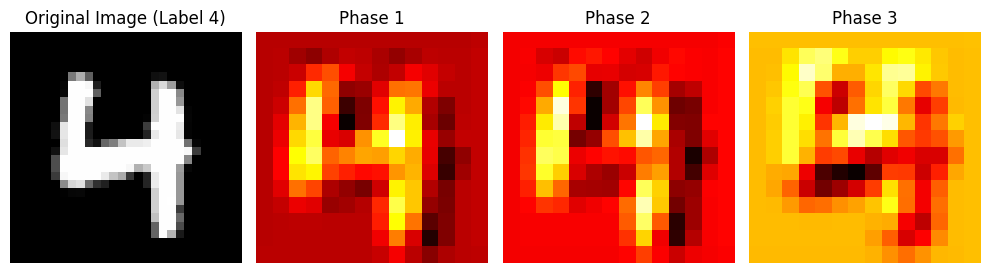

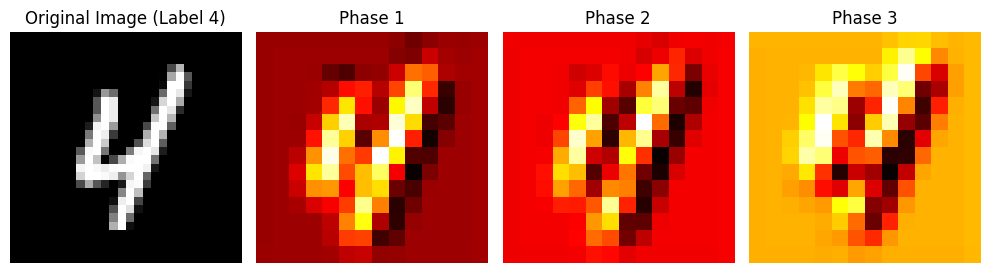

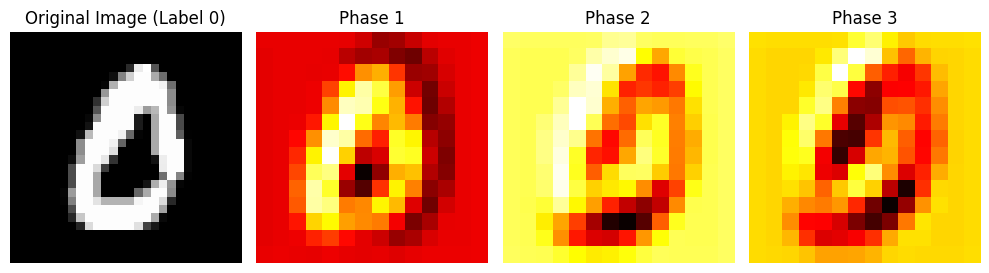

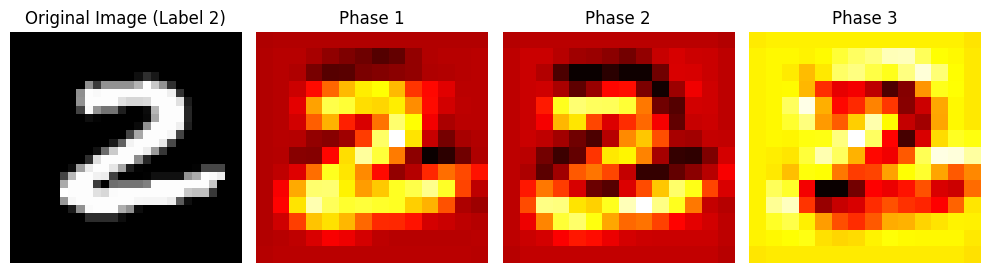

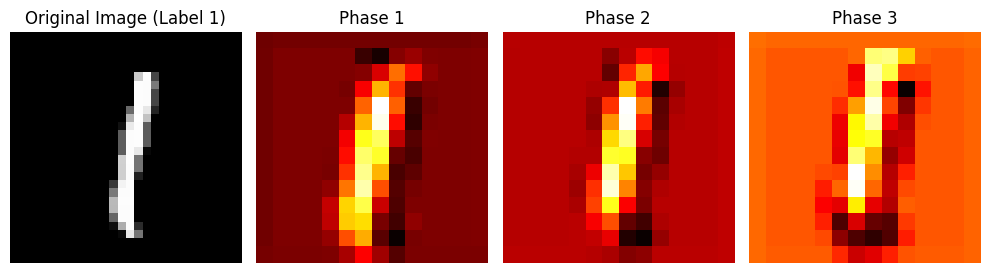

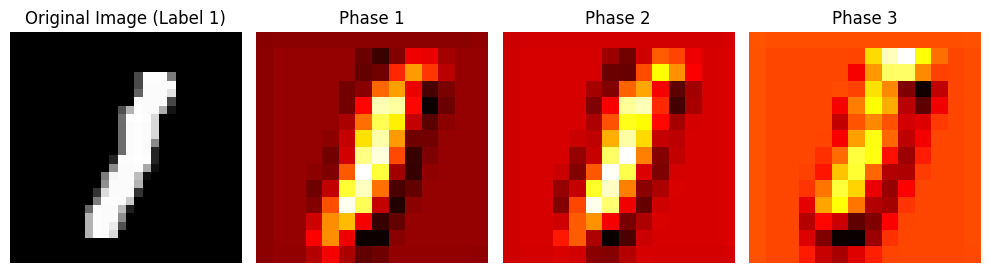

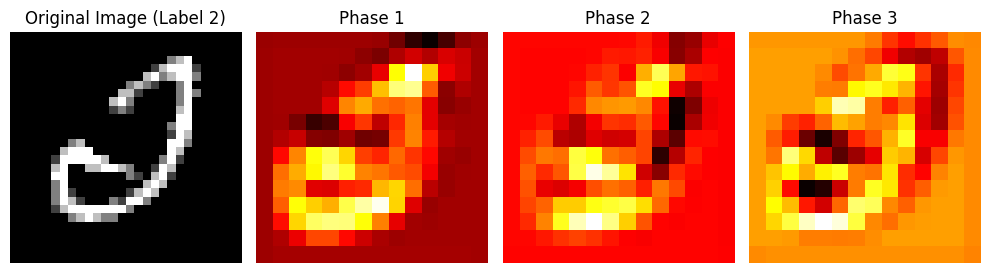

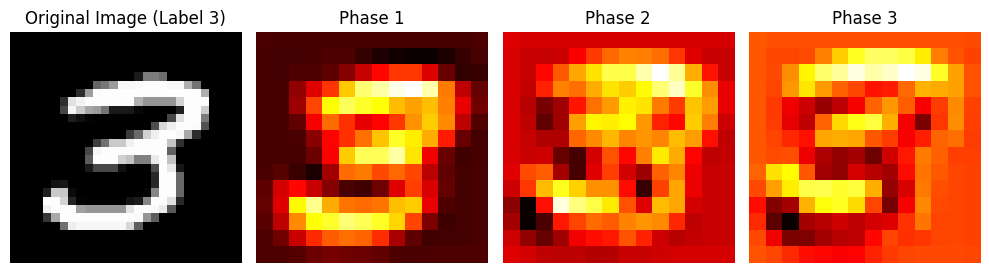

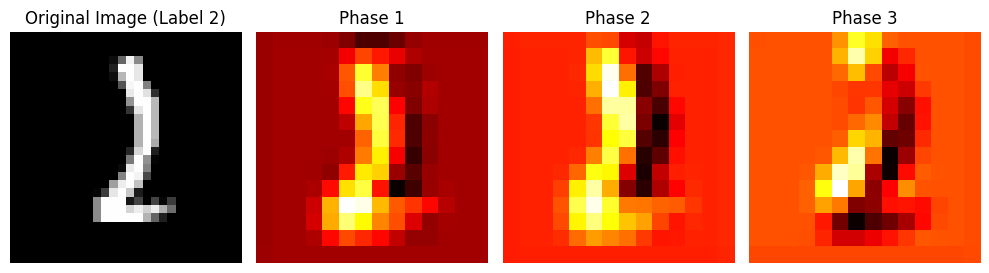

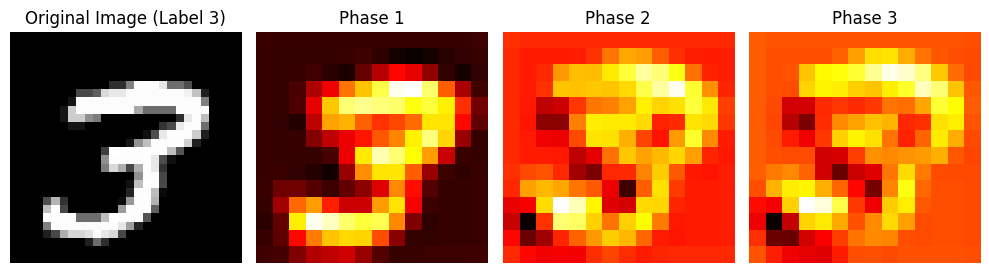

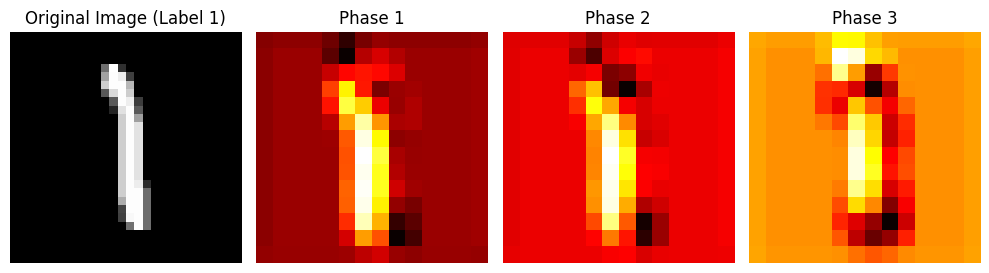

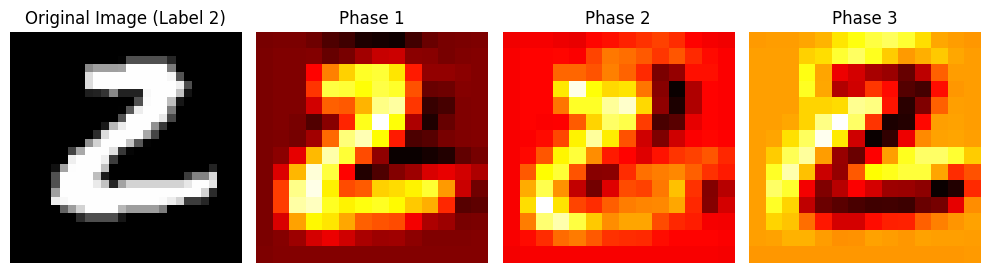

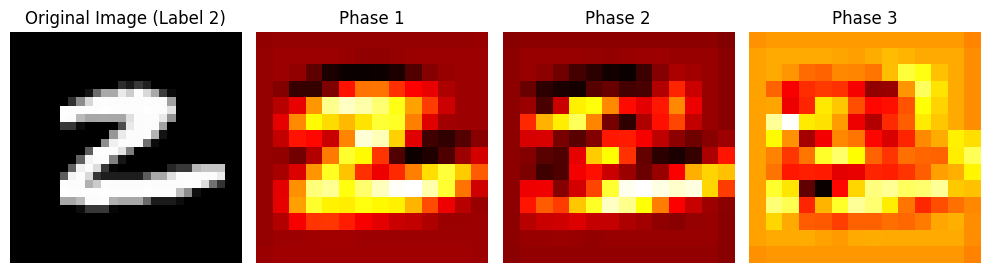

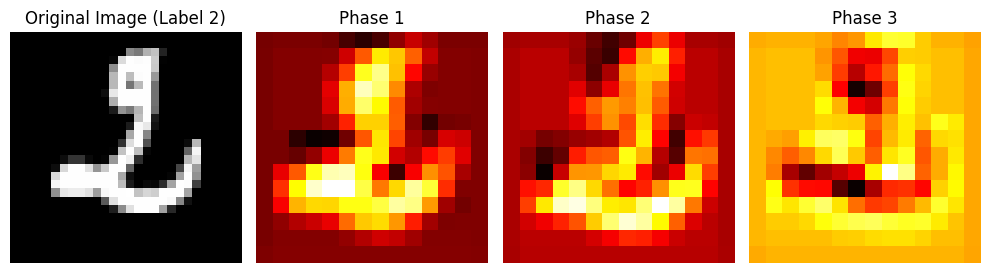

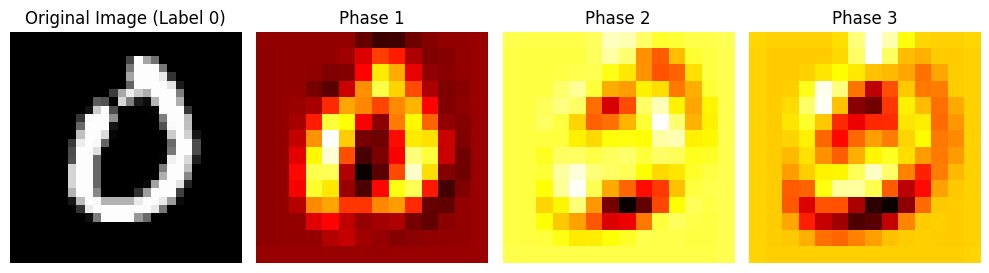

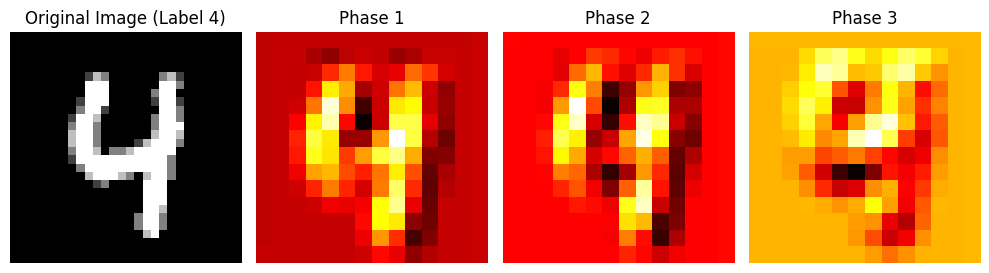

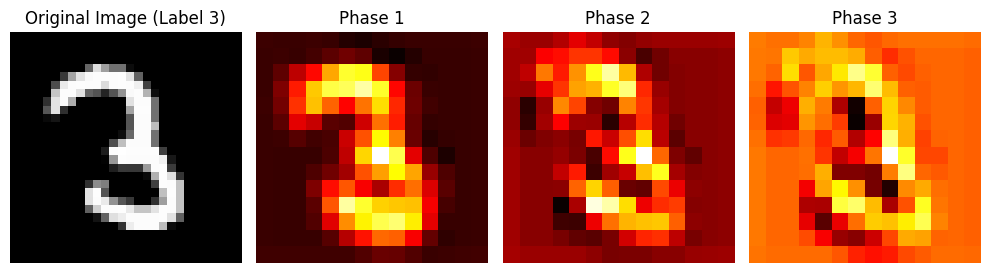

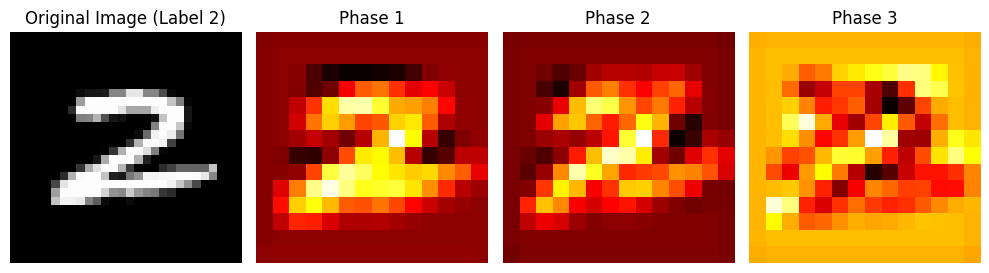

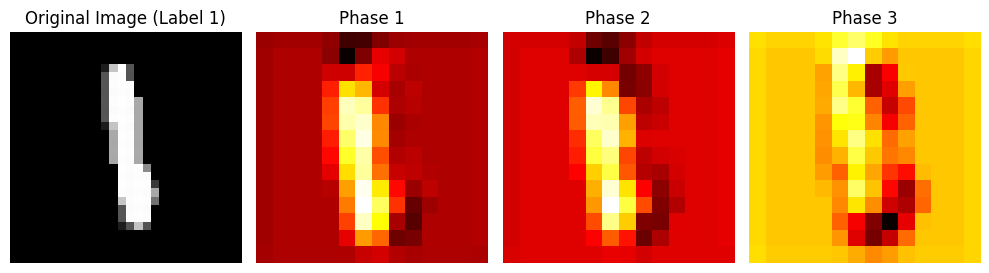

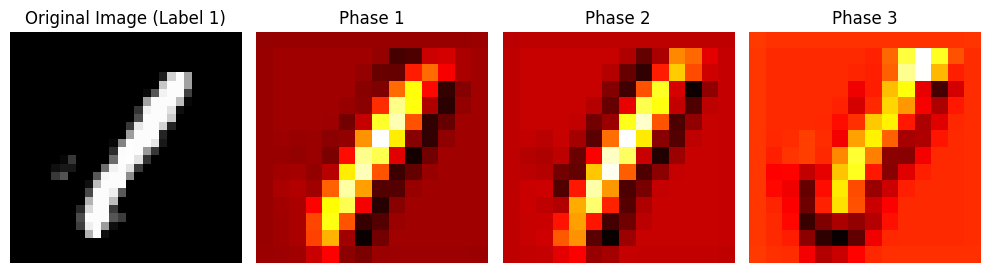

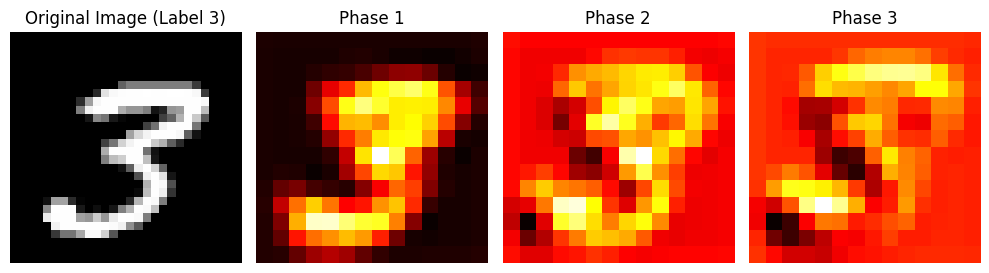

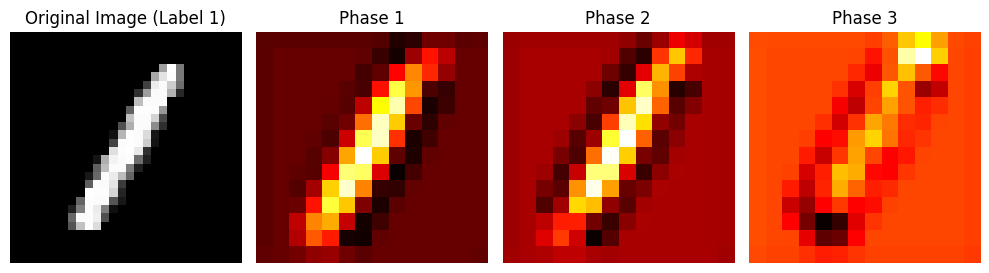

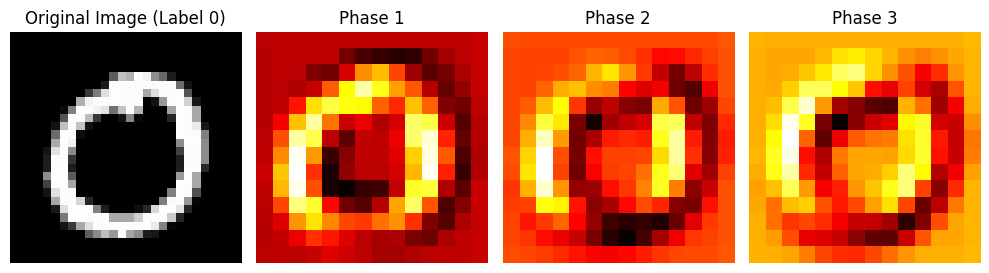

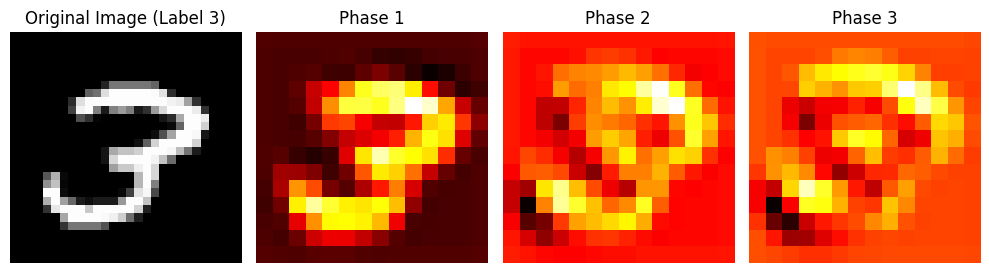

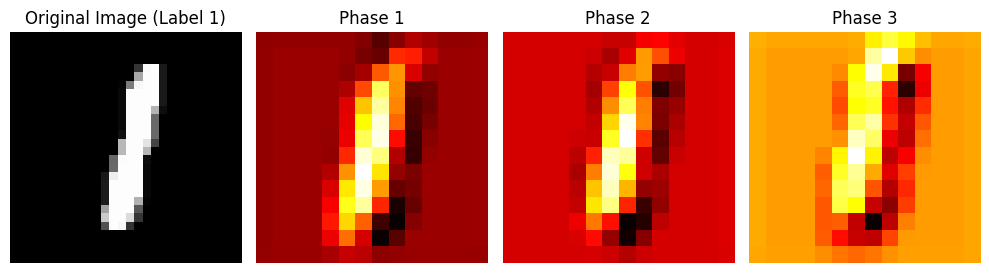

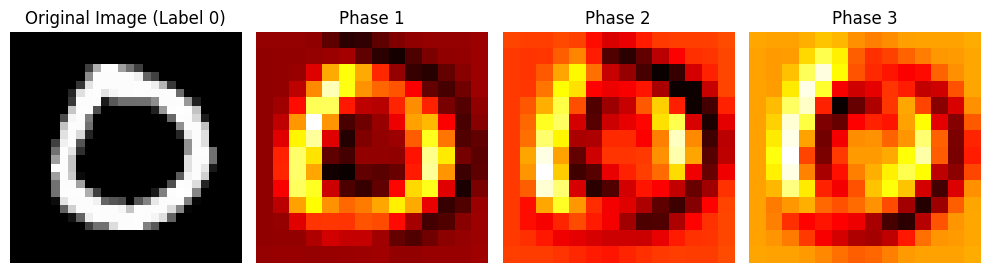

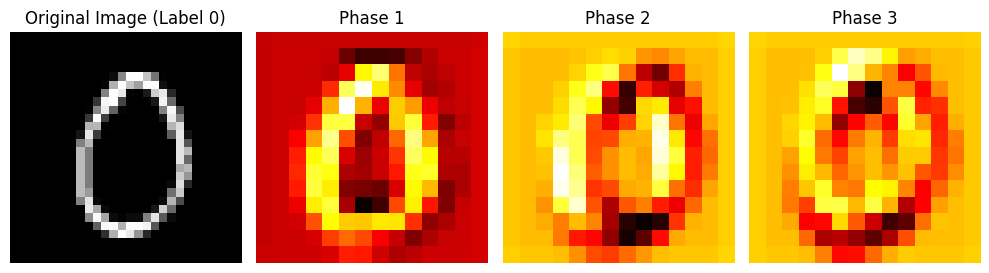

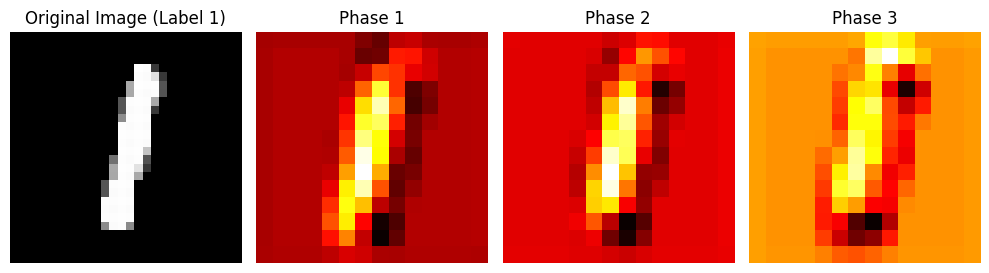

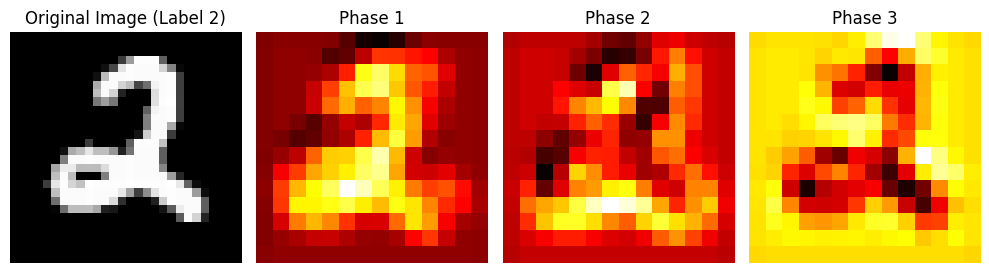

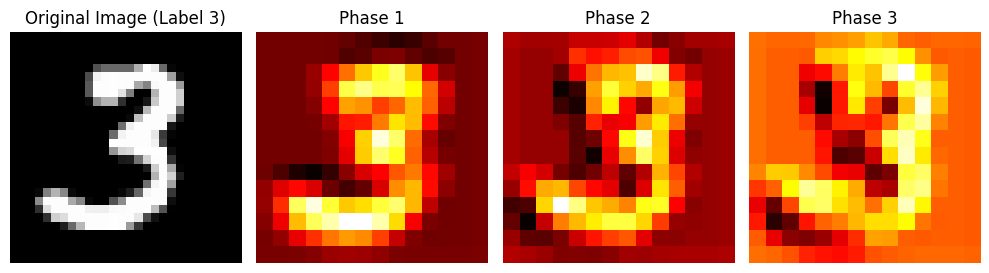

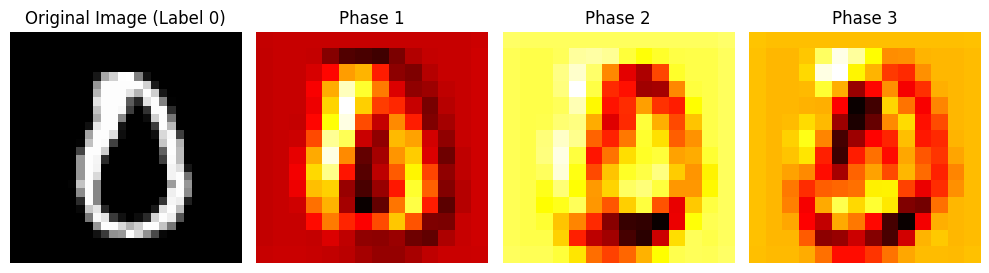

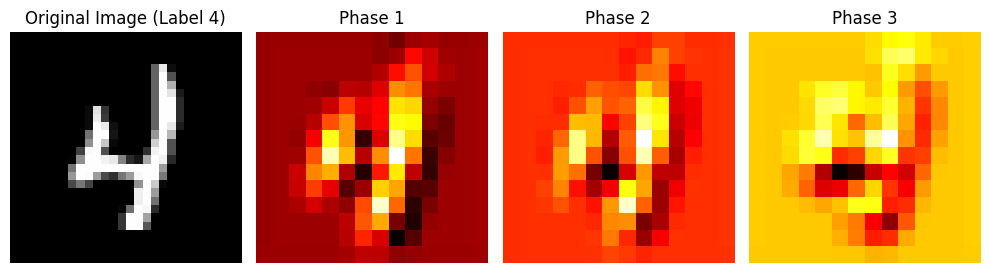

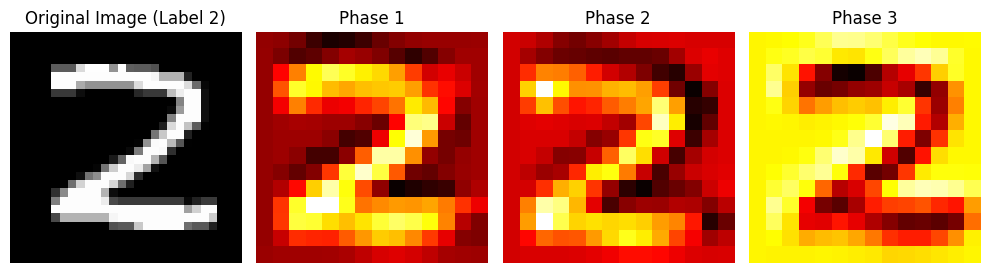

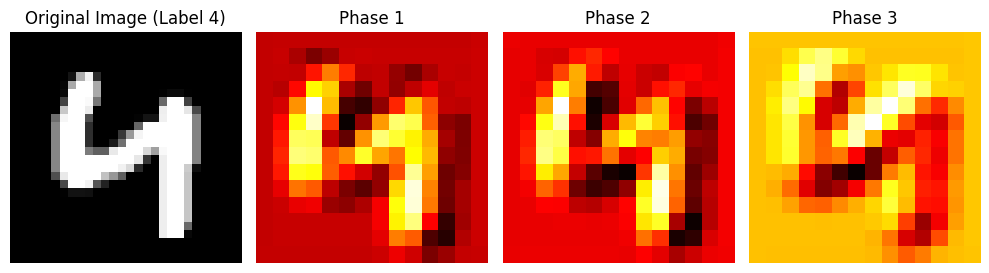

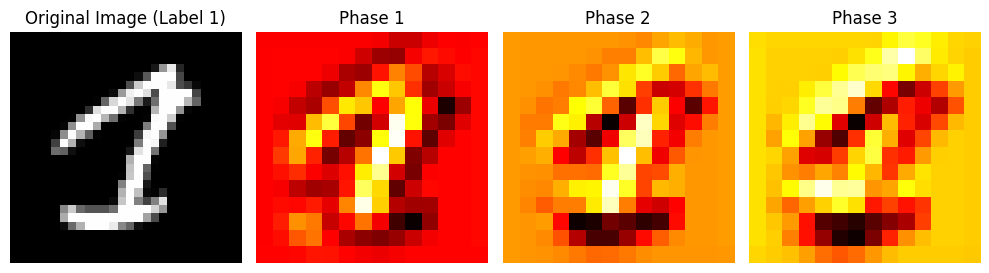

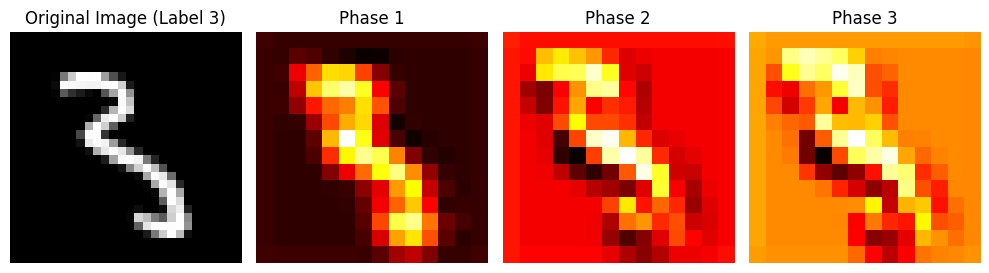

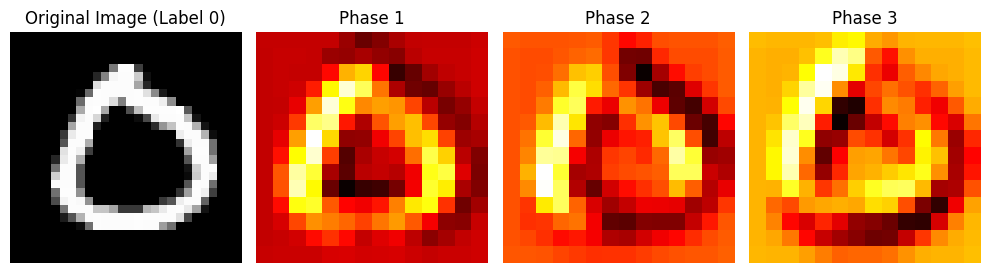

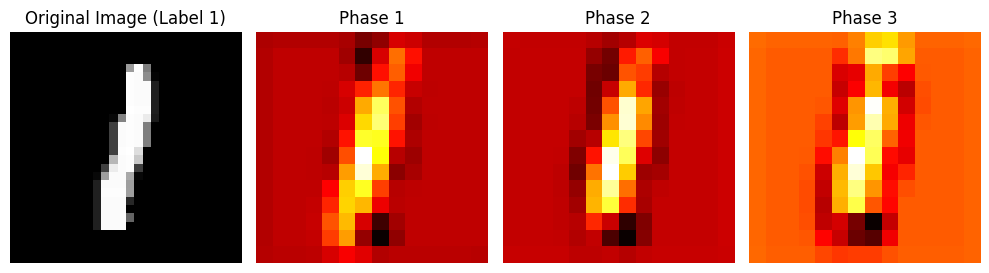

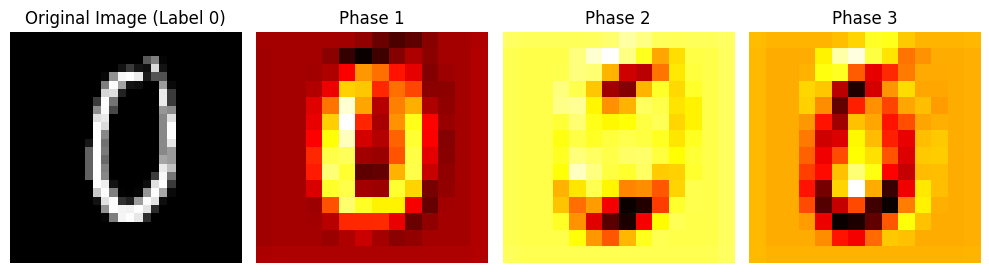

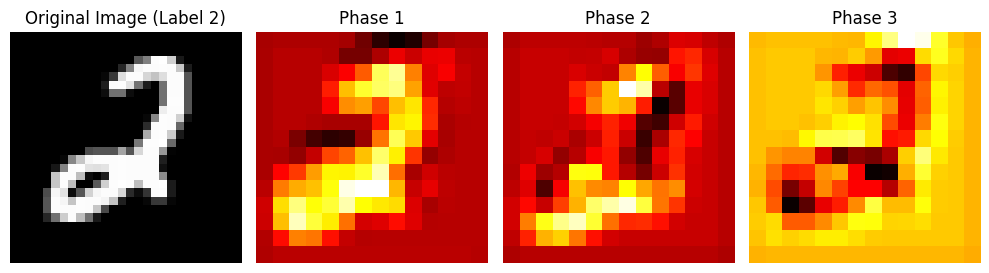

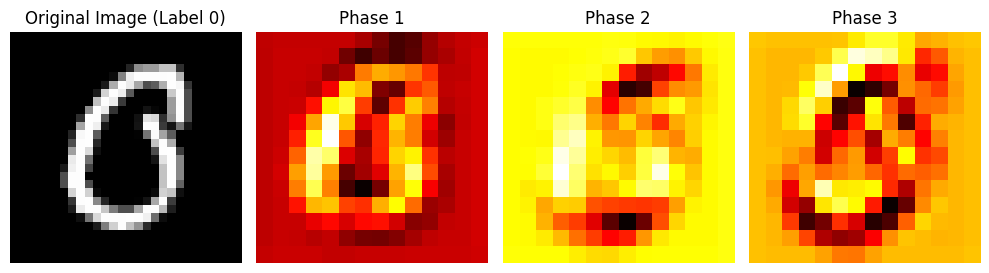

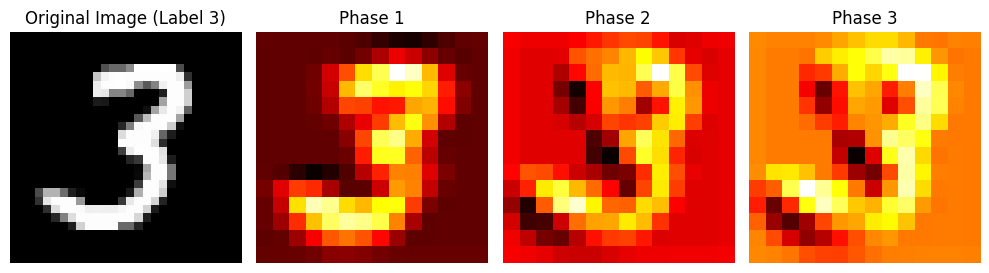

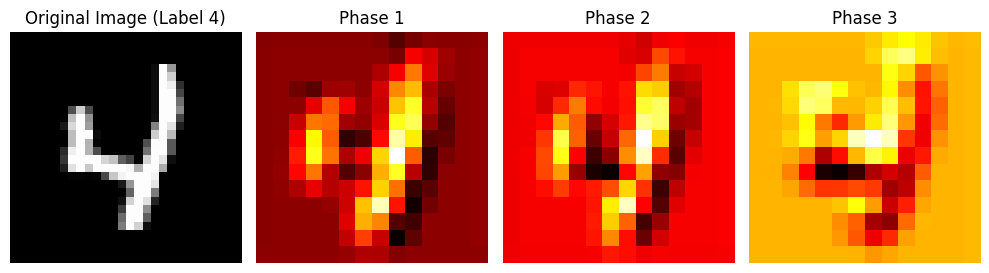

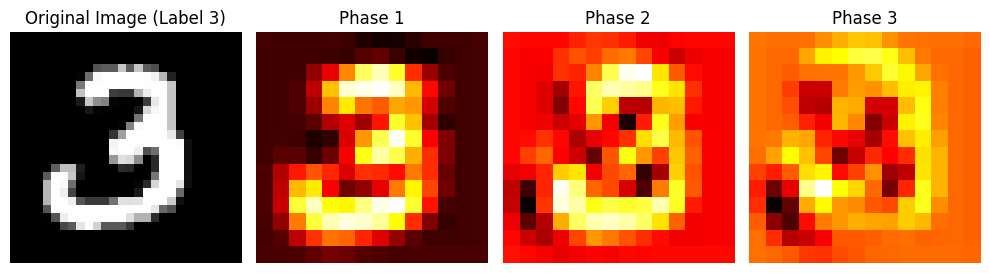

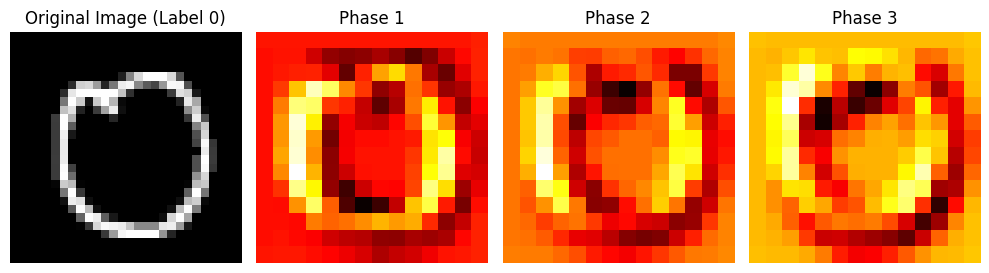

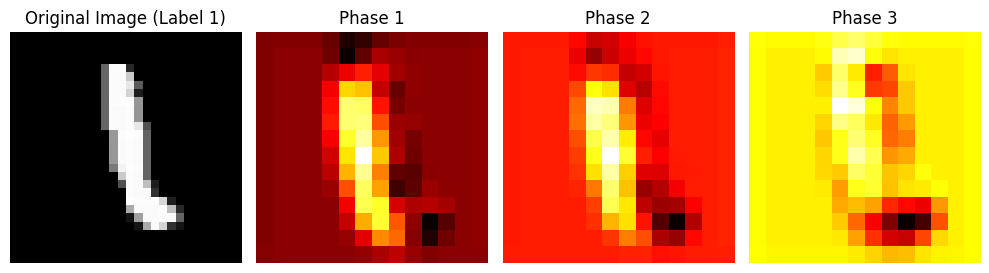

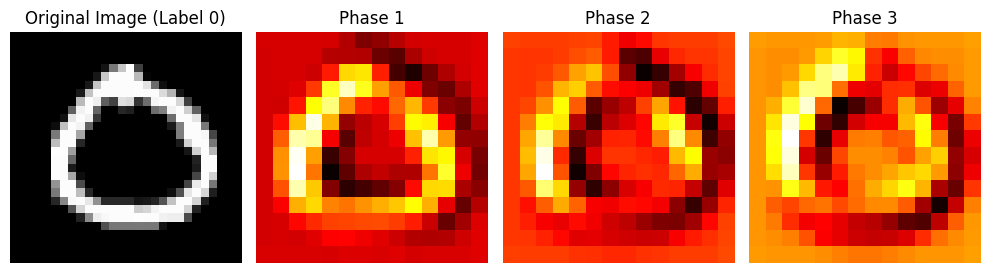

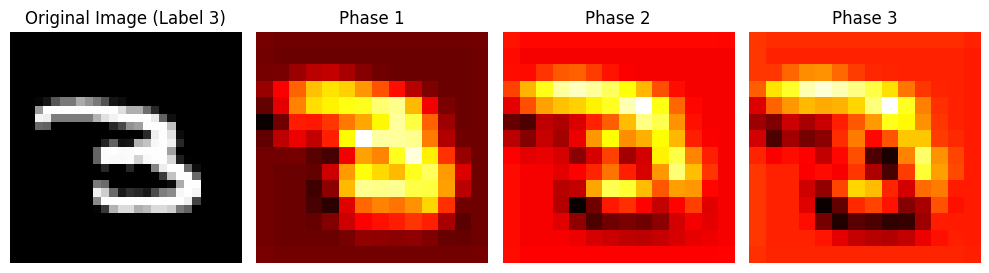

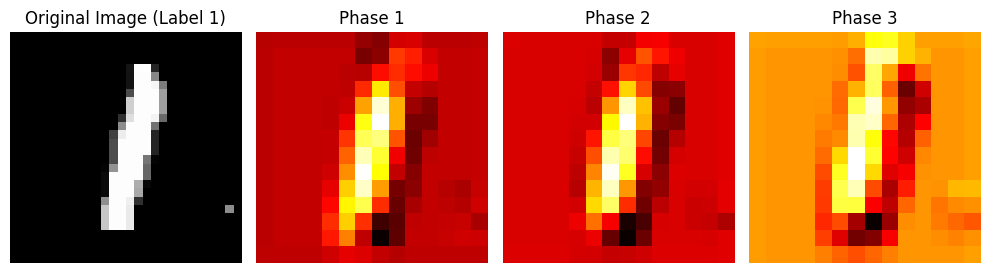

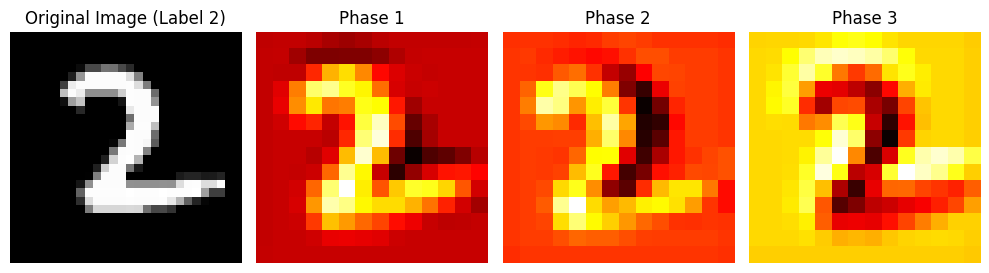

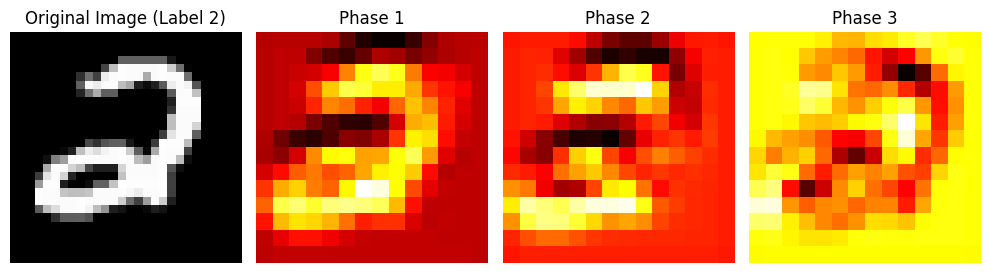

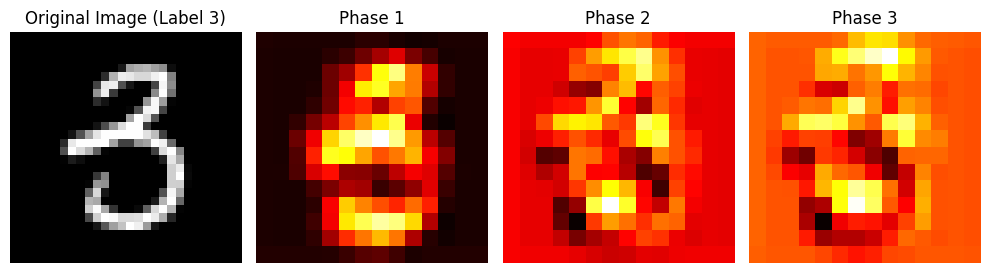

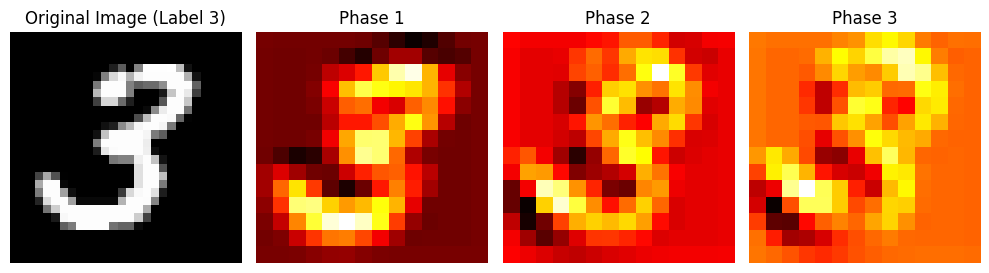

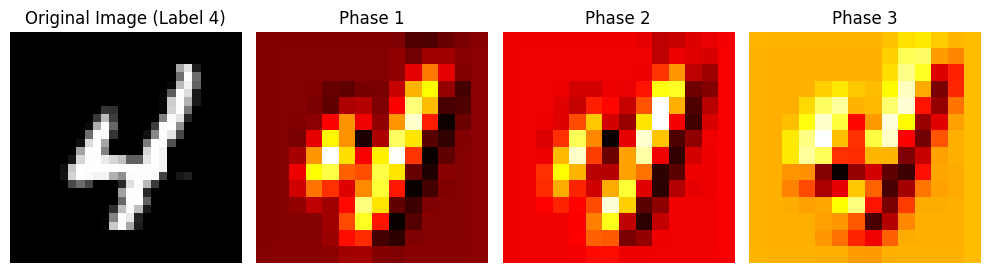

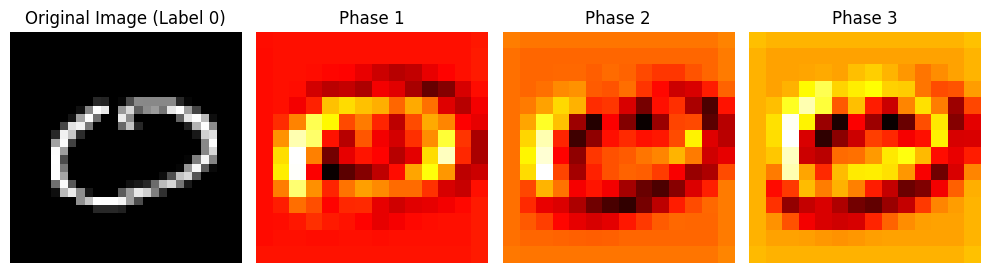

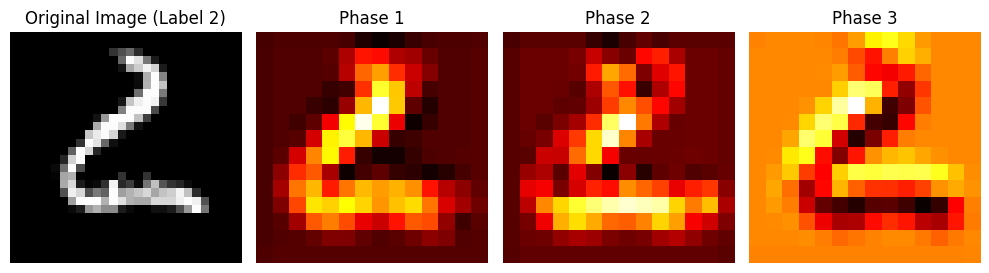

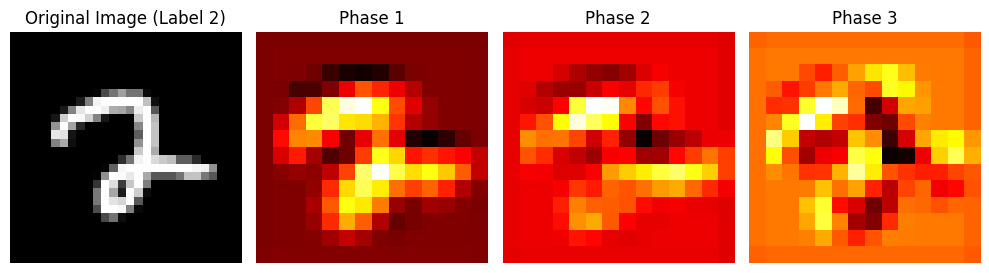

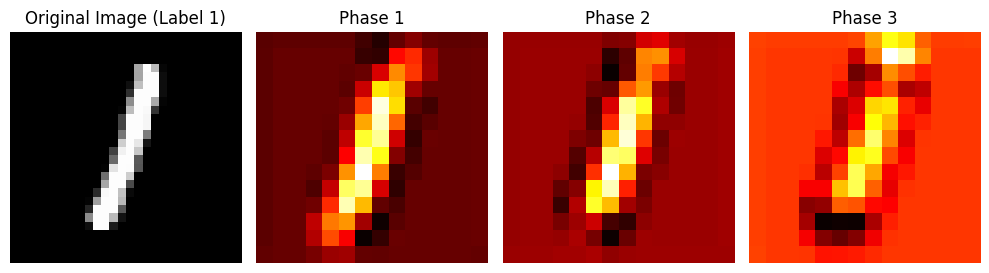

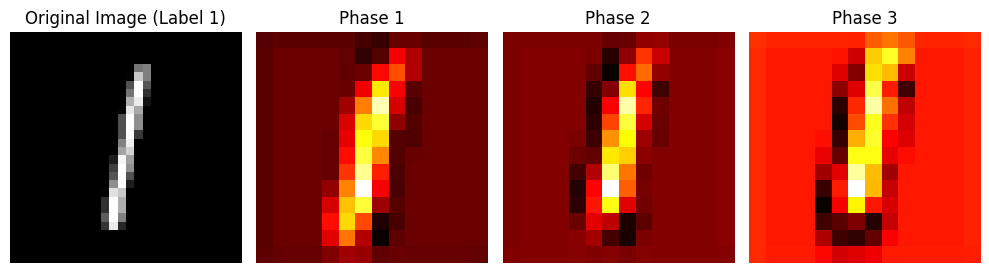

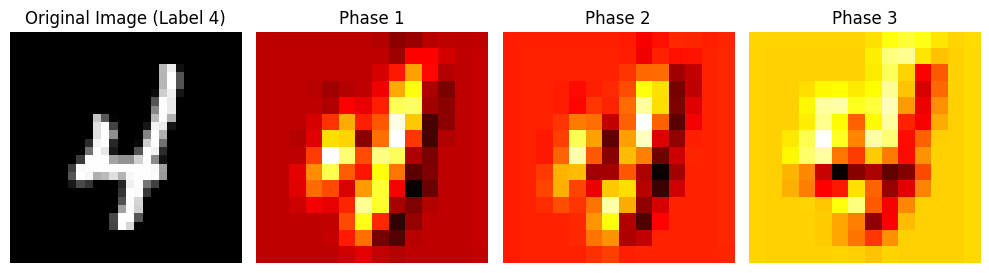

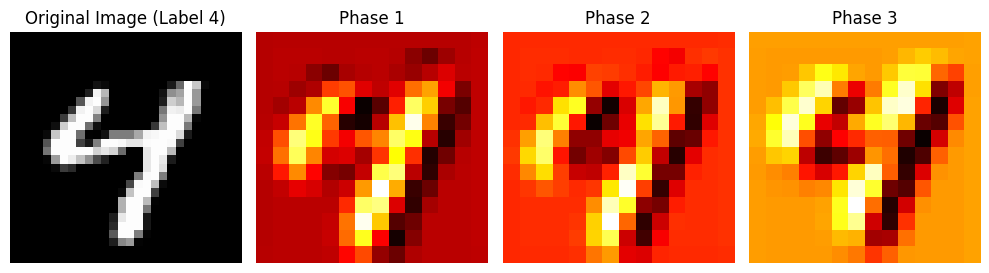

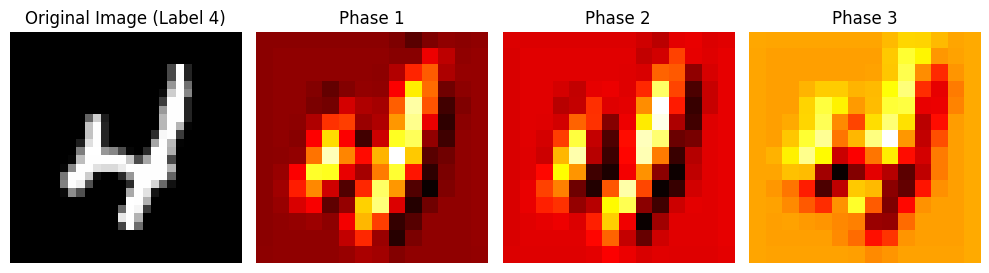

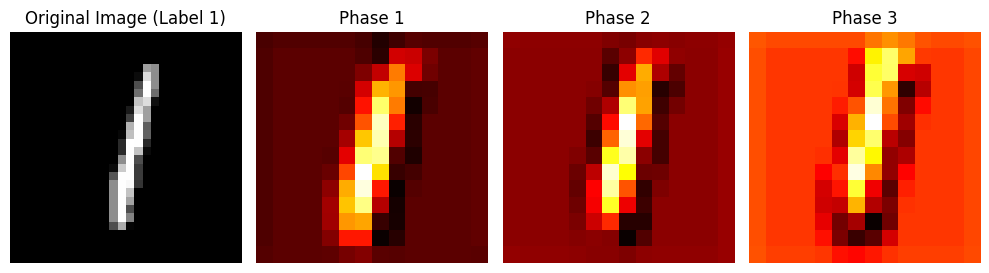

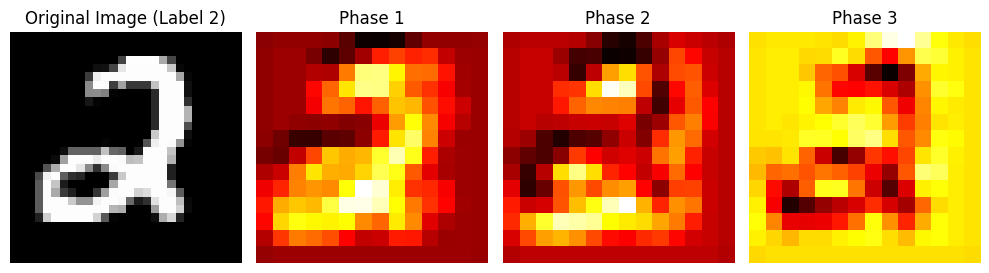

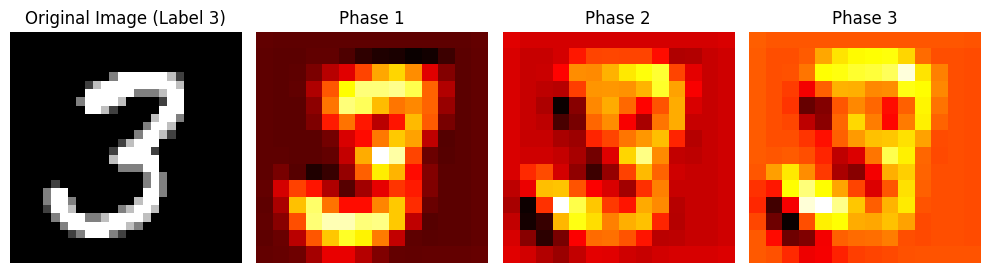

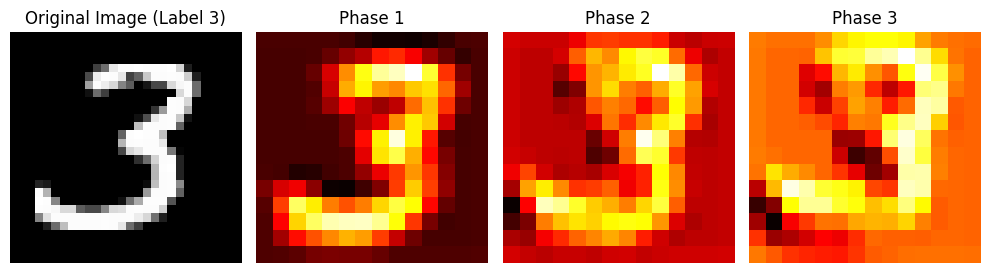

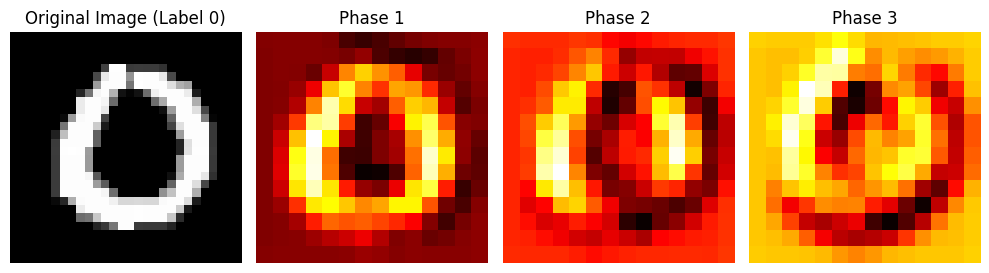

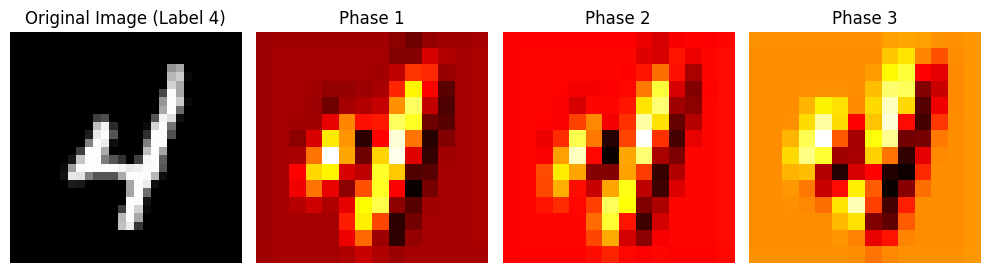

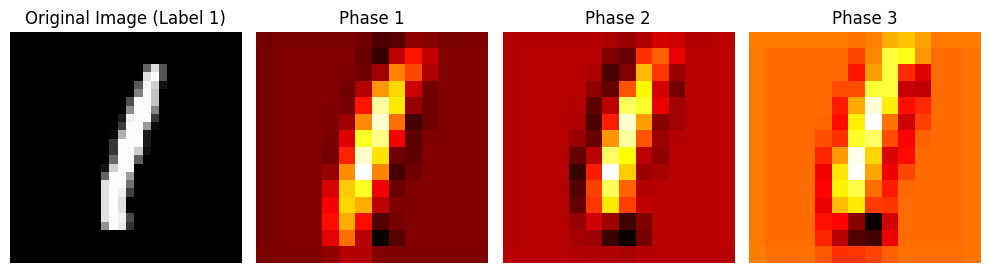

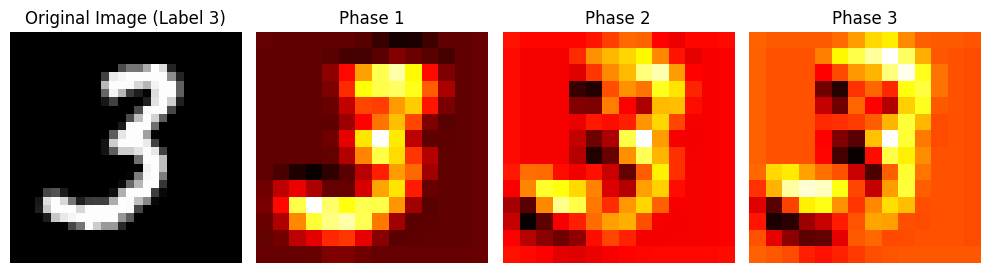

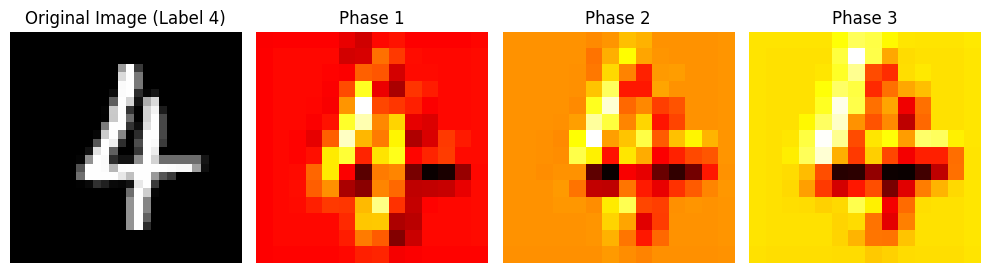

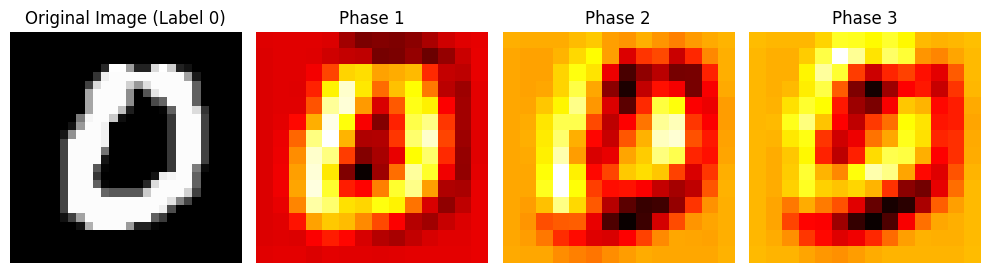

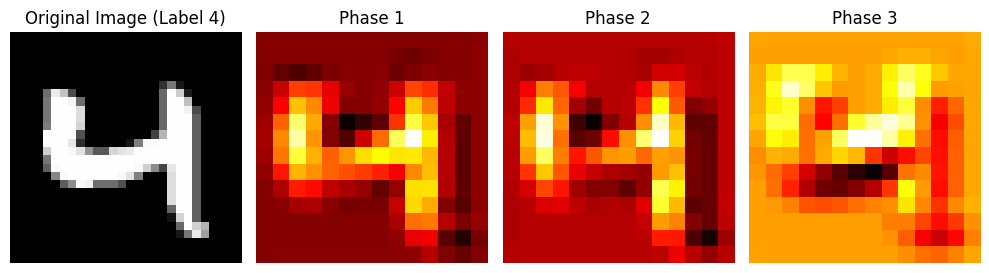

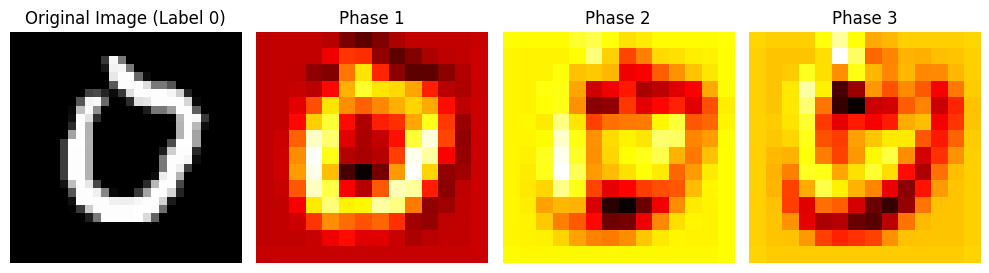

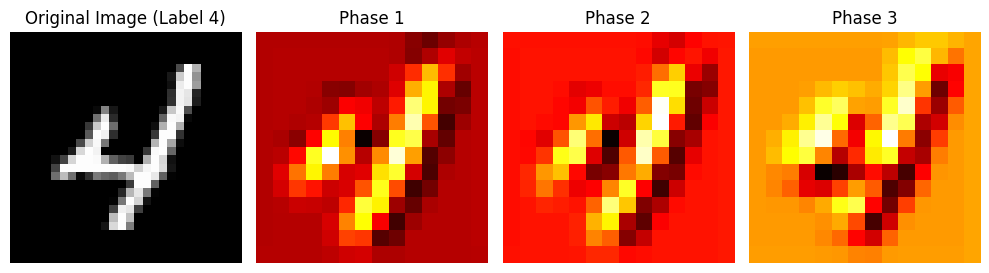

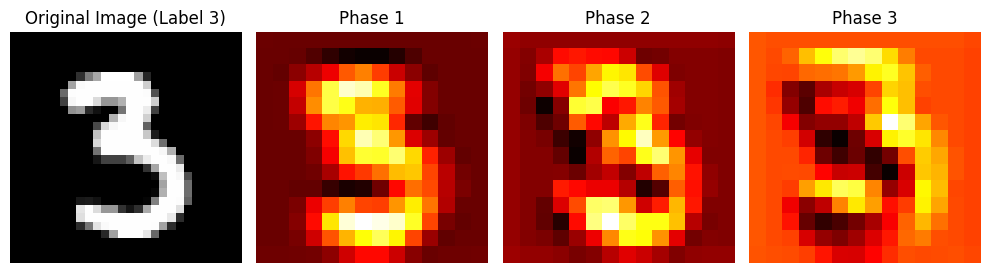

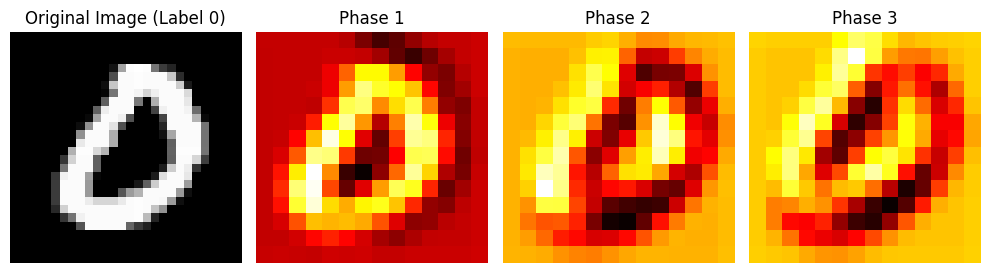

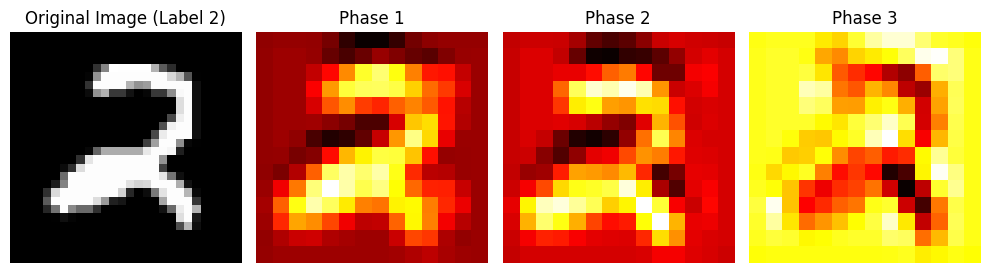

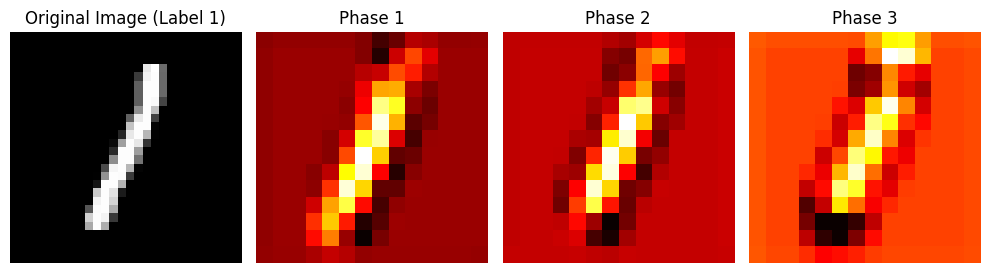

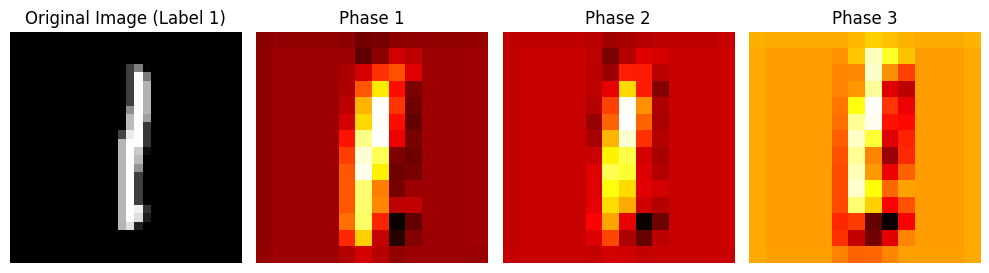

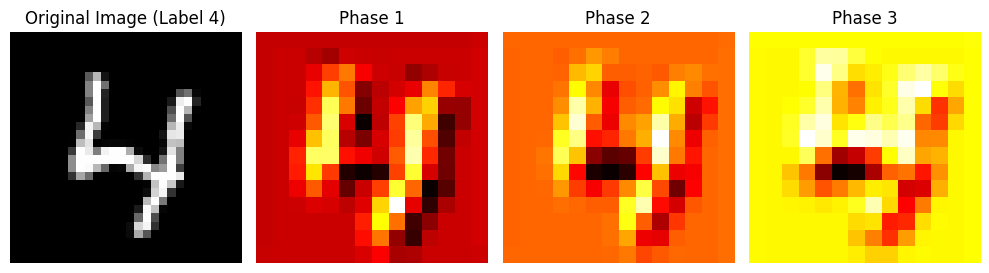

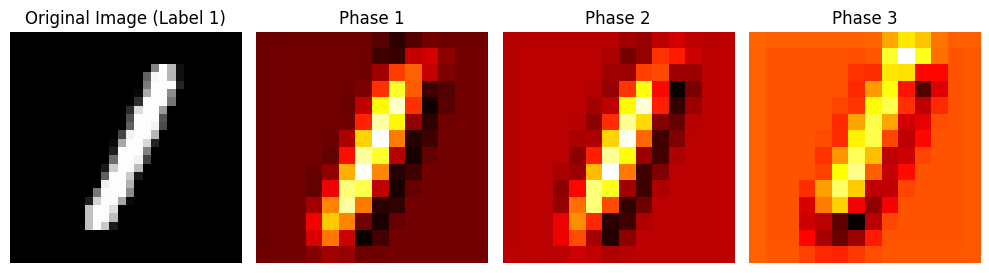

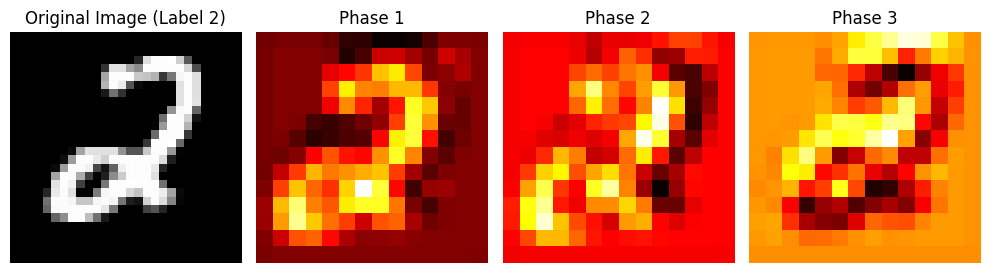

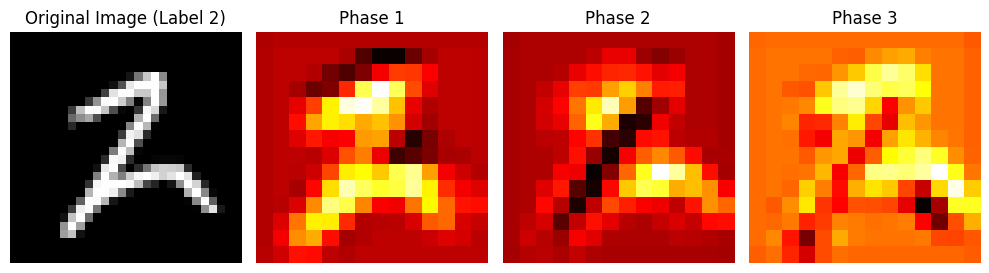

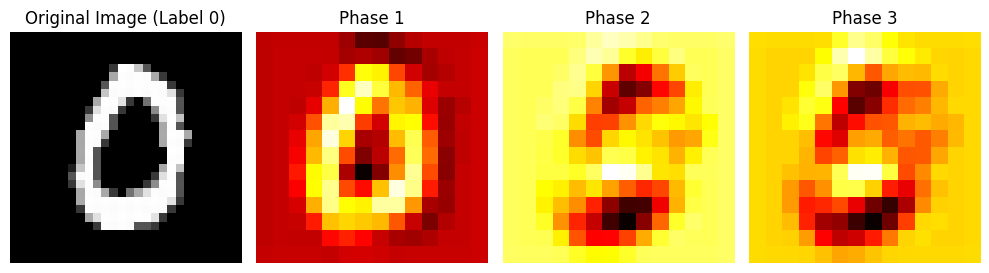

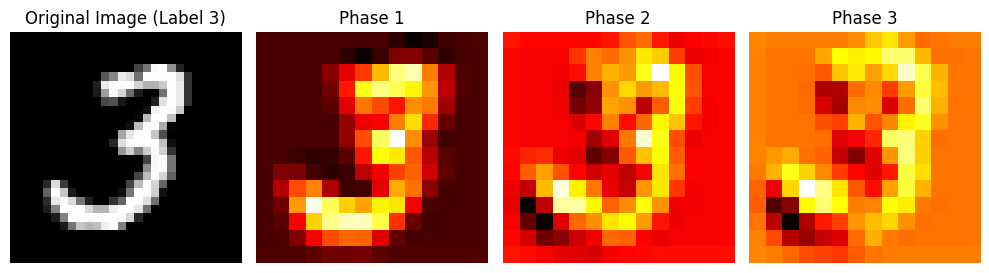

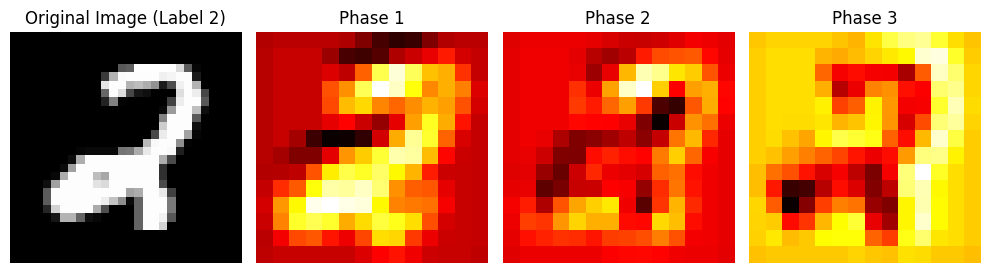

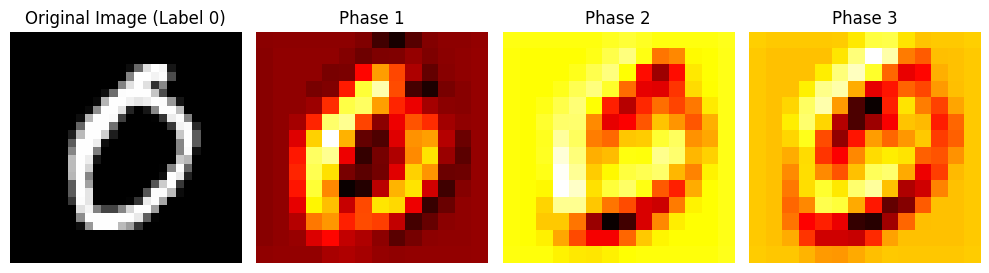

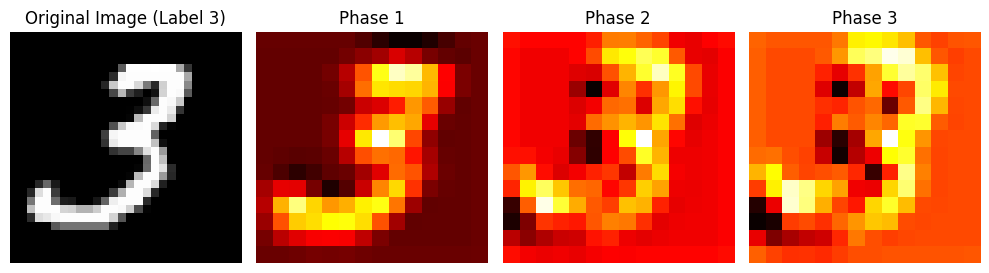

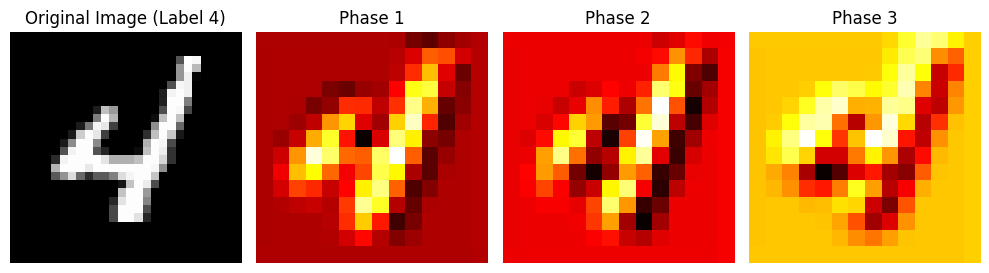

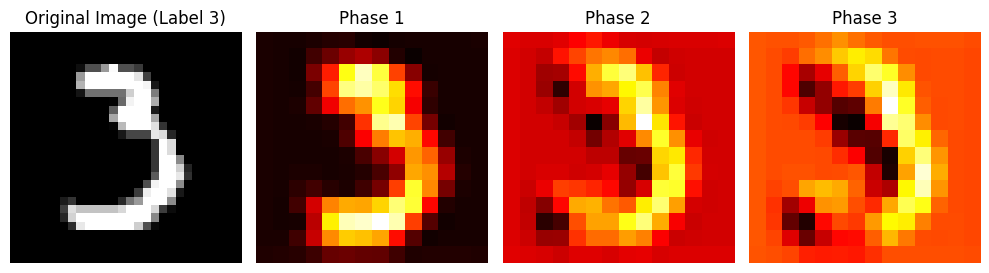

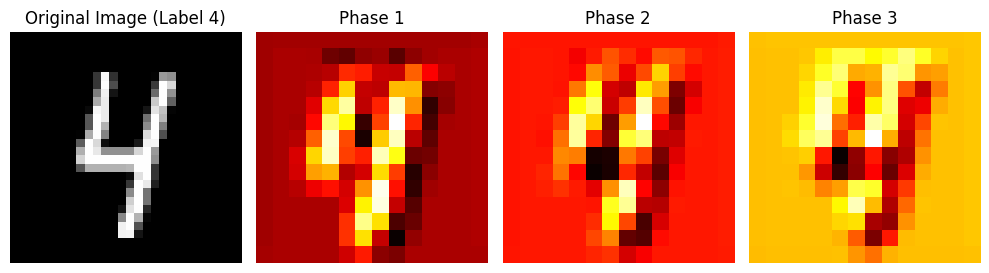

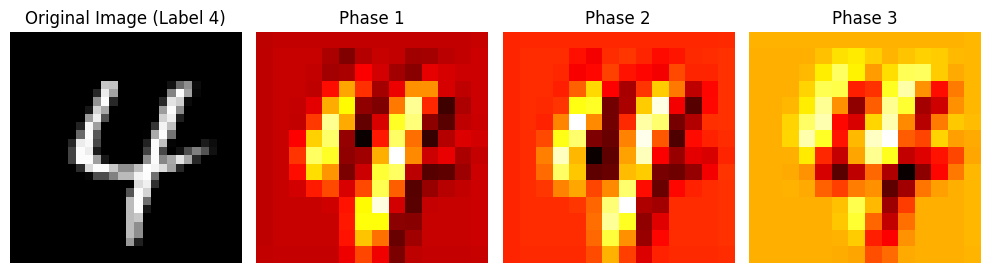

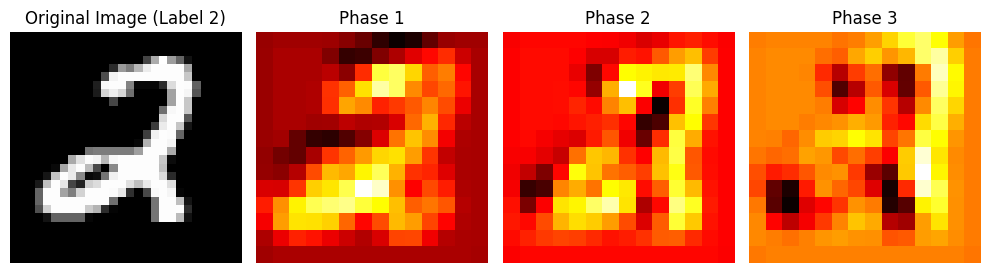

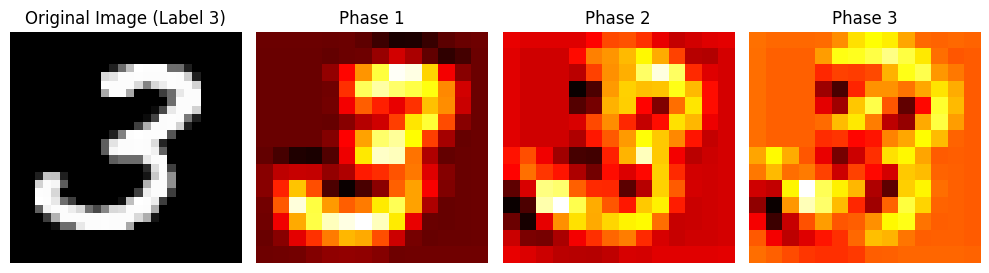

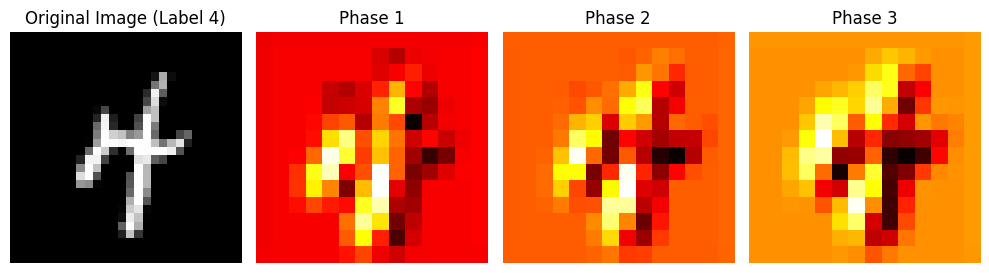

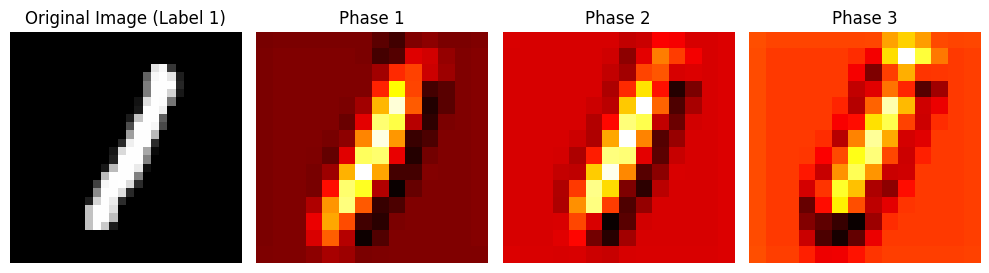

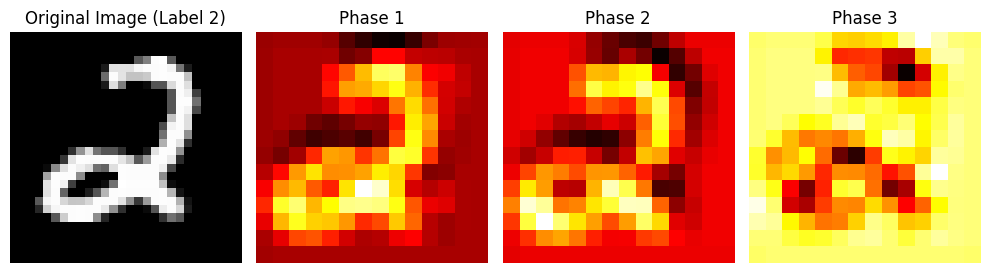

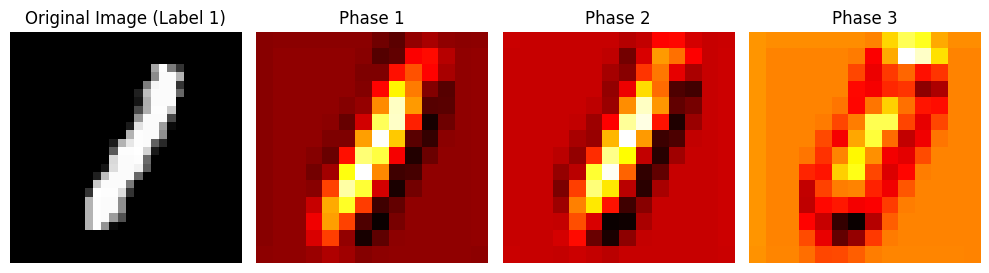

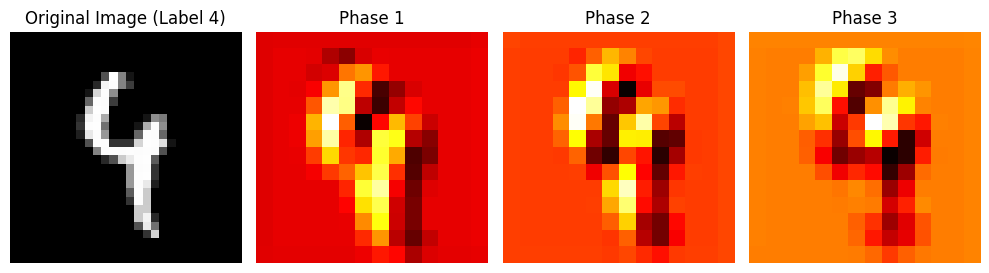

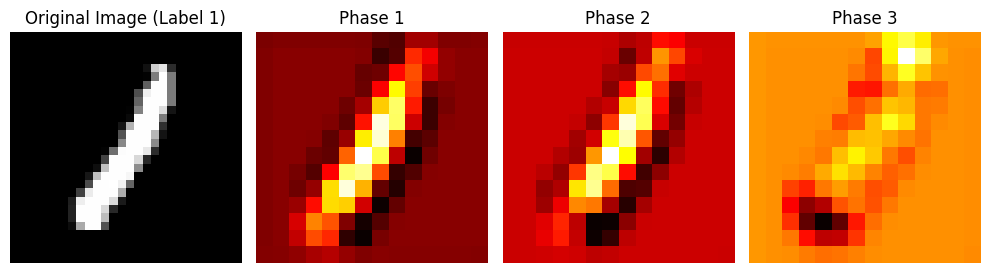

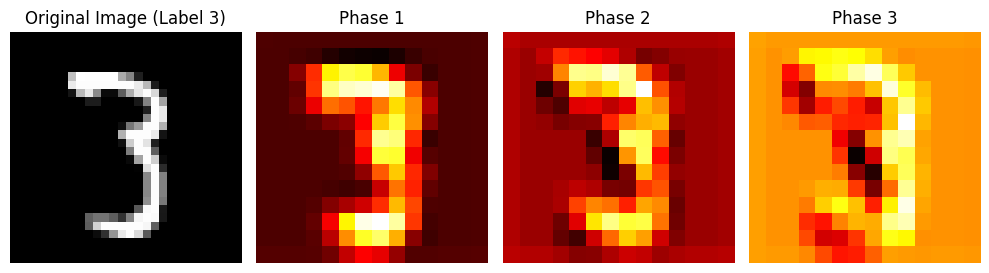

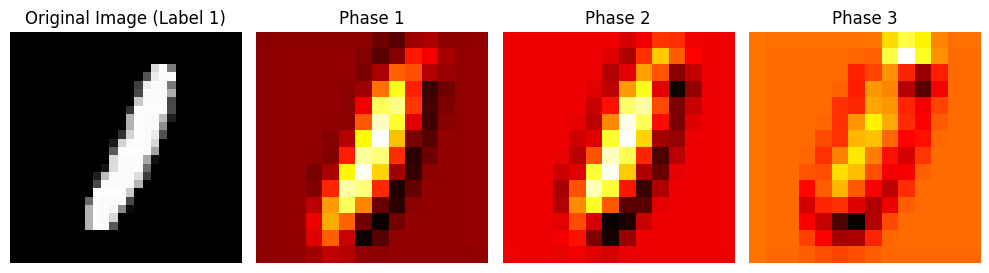

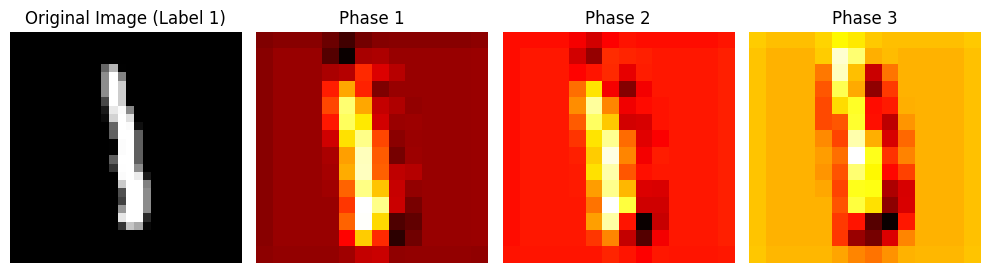

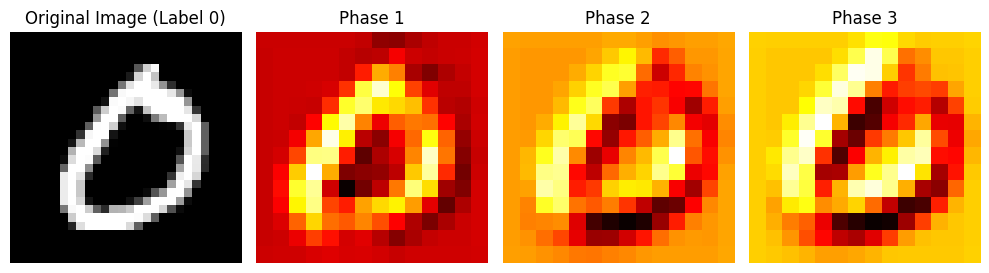

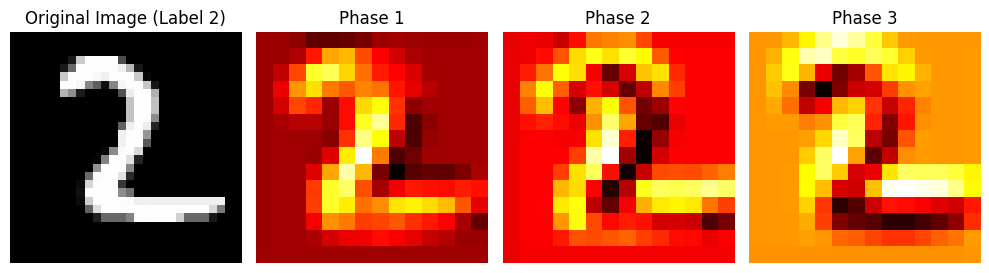

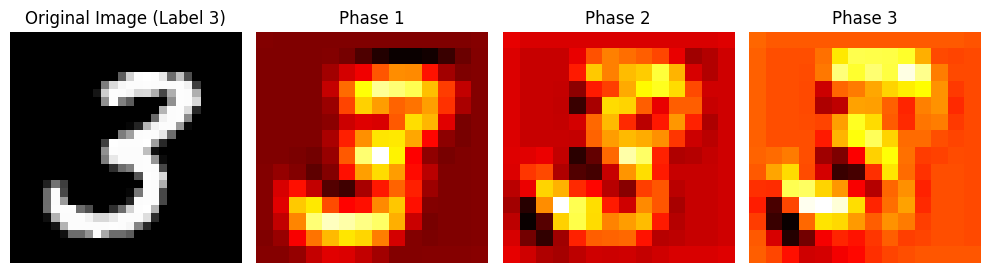

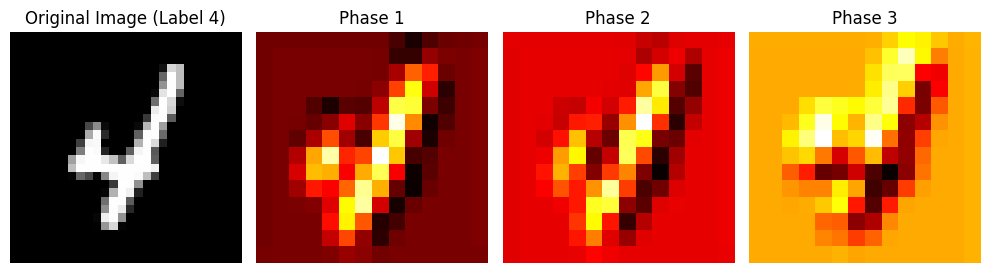

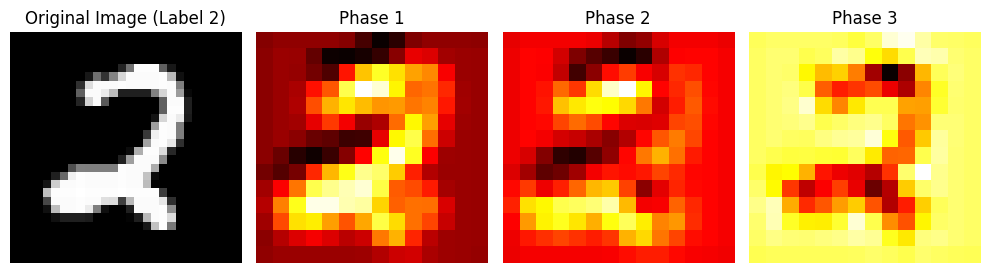

In [103]:
# Number of images to visualize
N = 200
sample_imgs = p1_images[:N]
sample_lbls = p1_labels[:N]
sample_imgs_t = torch.from_numpy(sample_imgs).float().unsqueeze(1)/255.0

for i in range(N):
    img_t = sample_imgs_t[i].unsqueeze(0)  
    lbl   = sample_lbls[i]  

    # Generate Grad-CAM heatmaps for each phase
    hm_p1 = generate_gradcam(model_phase1, img_t, lbl)
    hm_p2 = generate_gradcam(model_phase2, img_t, lbl)
    hm_p3 = generate_gradcam(model_phase3, img_t, lbl)

    # Plot: Original image + 3 heatmaps
    plt.figure(figsize=(10, 3.2))
    #plt.suptitle(f"Grad-CAM Evolution for Digit {lbl} Across Phase", fontsize=14)

    # Original Image
    plt.subplot(1, 4, 1)
    plt.title(f"Original Image (Label {lbl})")
    plt.imshow(sample_imgs[i], cmap='gray')
    plt.axis('off')

    # Grad-CAM Phase 1
    plt.subplot(1, 4, 2)
    plt.title("Phase 1")
    plt.imshow(hm_p1, cmap='hot')
    plt.axis('off')

    # Grad-CAM Phase 2
    plt.subplot(1, 4, 3)
    plt.title("Phase 2")
    plt.imshow(hm_p2, cmap='hot')
    plt.axis('off')

    # Grad-CAM Phase 3
    plt.subplot(1, 4, 4)
    plt.title("Phase 3")
    plt.imshow(hm_p3, cmap='hot')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 9) Visualizing Grad-CAM Heatmaps Across Phases

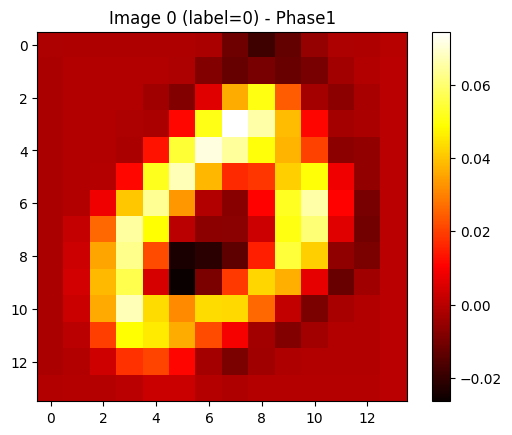

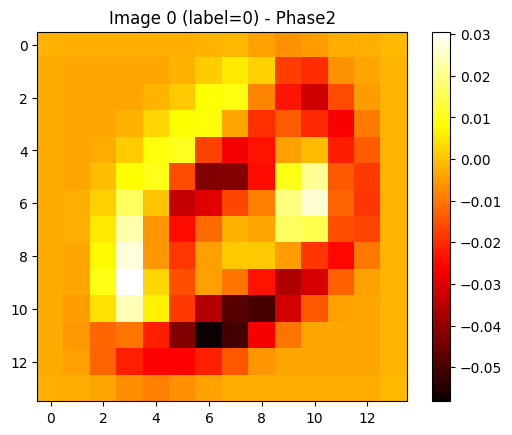

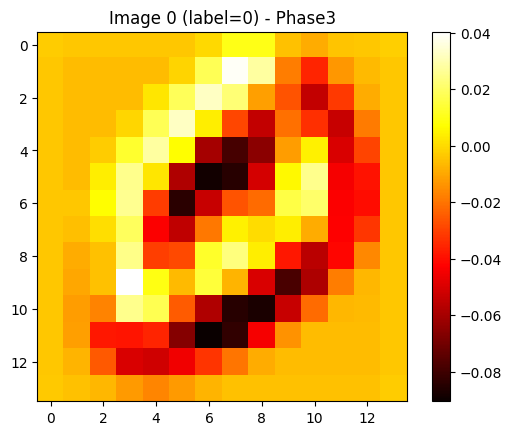

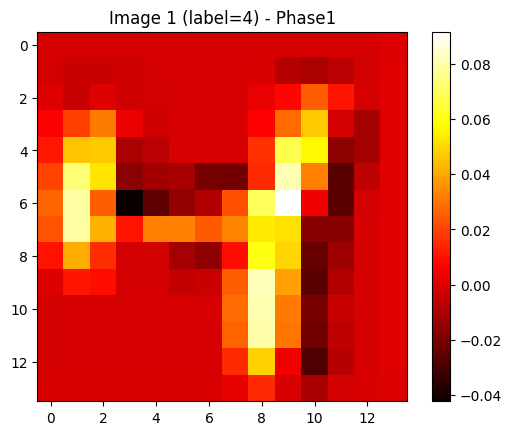

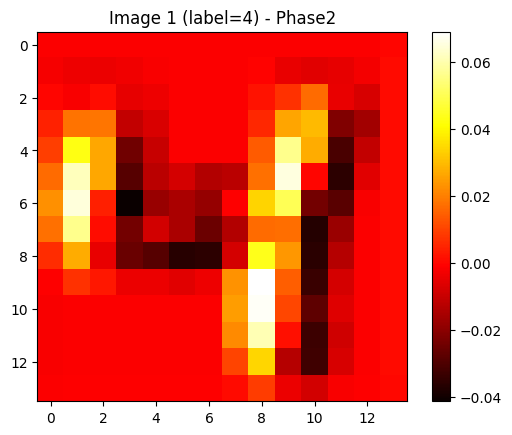

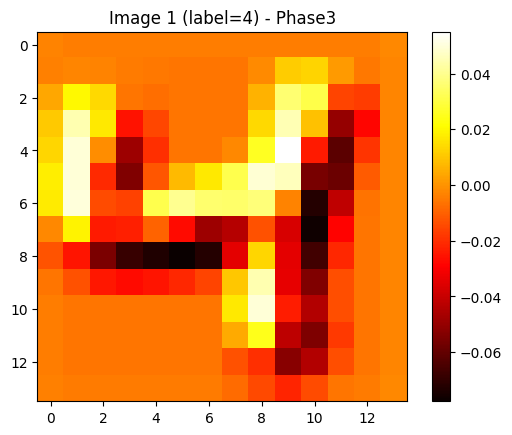

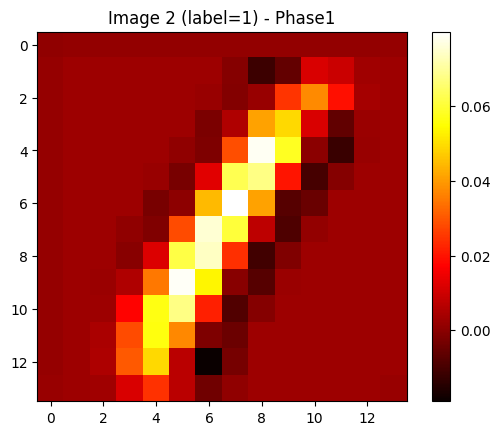

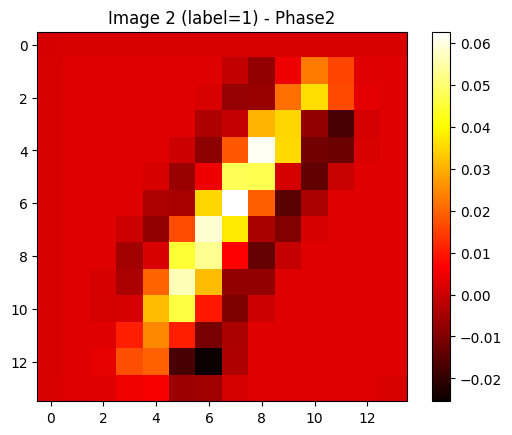

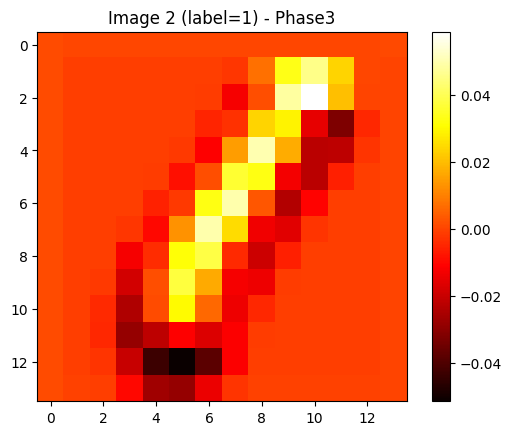

In [104]:
# HEATMAP VISUALIZATION
def show_heatmap(hm, title=""):
    plt.imshow(hm, cmap='hot')
    plt.title(title)
    plt.colorbar()
    plt.show()

def show_image(img, title=""):
    # Convert the image tensor to a NumPy array
    img_np = img.cpu().permute(1, 2, 0).numpy()
    plt.imshow(img_np)
    plt.title(title)
    plt.axis("off")
    plt.show()

for i in range(3):
    img_t = sample_imgs_t[i].unsqueeze(0)
    lbl   = sample_lbls[i]
    
    # Show the original image input
    #show_image(sample_imgs_t[i], title=f"Original Image {i} (label={lbl})")

    hm_p1 = generate_gradcam(model_phase1, img_t, lbl)
    hm_p2 = generate_gradcam(model_phase2, img_t, lbl)
    hm_p3 = generate_gradcam(model_phase3, img_t, lbl)

    # Show each heatmap
    show_heatmap(hm_p1, title=f"Image {i} (label={lbl}) - Phase1")
    show_heatmap(hm_p2, title=f"Image {i} (label={lbl}) - Phase2")
    show_heatmap(hm_p3, title=f"Image {i} (label={lbl}) - Phase3")
